In [1]:
! pwd

/home/guillermo.carrilho/PhysicsSimulationDeepLearning


In [1]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

# stable difusion approach

In [38]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *


geo=UniformGrid(x=500, y=500,bounds=Box(x=5e3, y=5e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':4e3,
          'x+': 4e3,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phi_o=Field( geo,values=tensor(1142.0),
      boundary= {
          'x-': 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phy=two_phase_flow(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    #w_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v),
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    #o_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v)
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
)

from Differentiable_simulation import K_o_f_t,K_w_f_t,S_w,dK_o,dK_w,dK_o,dsdpc
#from Differentiable_simulation import *
#dsdpc=(lambda p_c:math.clip((-1*LAMBDA)*((S_w(p_c)-SWR)/PD),lower_limit=1e-6))
import anisotropic_diffusion
print(phy.compute_p_c(phi_w,phi_o))
print(S_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(S_w(phy.compute_p_c(phi_w,phi_o))))
print(dsdpc(phy.compute_p_c(phi_w,phi_o)))

print(dK_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_o,phi_w,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(phi_w,phi_o)))
print(dK_o(phy.compute_p_c(phi_w,phi_o)))
#print(phy.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(phi_w,phi_o, 1e-4).sample(phi_o.geometry))

PD=2e3
SWR=0.3
SOR=0.1
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.3))
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.7))

(xˢ=500, yˢ=500) const 1142.0
(xˢ=500, yˢ=500) const 0.8999999761581421
(xˢ=500, yˢ=500) const 0.049999989569187164
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -0.007 ± 0.226 (-7e+00...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)


Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

In [ ]:
import matplotlib.pyplot as plt

class two_phase_flow(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(self.phi_w,self.phi_o)
    convective_velocity = grad_phi_dK(phi_a,dK_a(p_c))\
                         - grad_phi_dK(phi_b,dK_b(p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity

  #def compute_anisotropic_viscosity_effect(self):
    # reformulate differential solver
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    #grad_phi_w=field.spatial_gradient(self.phi_w,self.phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)
    w_advection_term = dt * advect.semi_lagrangian((phi_w),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_w.geometry)

    w_diffusion_term = dt * anisotropic_diffusion.implicit(phi_w,-1*K_w(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)
    #o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,K_o(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)

    pressure_chage_term = dt * (self.dtphi_o_1)

    return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(w_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    o_advection_term = dt * advect.semi_lagrangian((phi_o),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_o.geometry)

    o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,-1*K_o(p_c), dt=dt,correct_skew=False).sample(phi_o.geometry)

    pressure_chage_term = dt * (self.dtphi_w_1)

    return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_advection_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(o_diffusion_term)
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    print(((phi_o-phi_o_1)/dt).sample(geo))
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = math.solve_linear(self.phi_w_momentum_eq, phi_w, self.w_advection_solver(phi_w),phi_o, dt=-dt)
    print("w phse solved")
    new_phi_o = math.solve_linear(self.phi_o_momentum_eq, phi_o, self.o_advection_solver(phi_o),phi_w, dt=-dt)
    print("o phse solved")
    print(phi_o.sample(geo))
    print(new_phi_o.sample(geo))
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [ ]:
phi=(phi_w,phi_o)

In [ ]:
print(phy.dtphi_o_1.sample(geo))
print(phy.dtphi_w_1.sample(geo))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.dtphi_o_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))
print(phy.dtphi_w_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))

(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0


In [ ]:
phi=(phi_w,phi_o)
for i in range(1):
    phi=phy.implicit_time_step(*phi,1e-4)

Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

(xˢ=500, yˢ=500) -5.24e+01 ± 3.3e+05 (-5e+06...5e+06)
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 1142.0


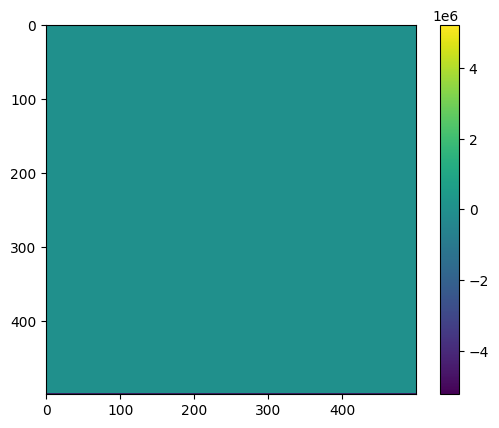

In [ ]:
#plt.imshow(phy.dtphi_o_1.sample(geo))
plt.imshow(phy.dtphi_w_1.sample(geo))
plt.colorbar()
print(phy.dtphi_w_1.sample(geo))
print(phy.dtphi_o_1.sample(geo))
print(phy.phi_o.sample(geo))

(xˢ=500, yˢ=500) -5.24e-05 ± 3.3e-01 (-5e+00...5e+00)


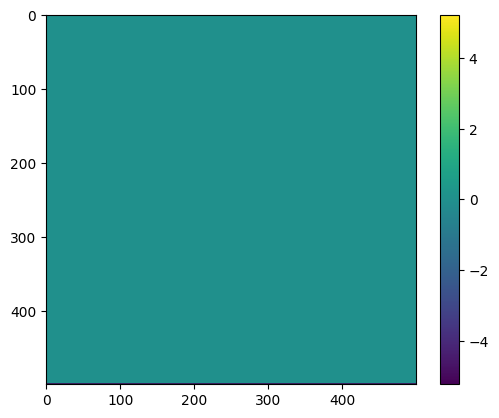

(xˢ=500, yˢ=500) const 1142.0


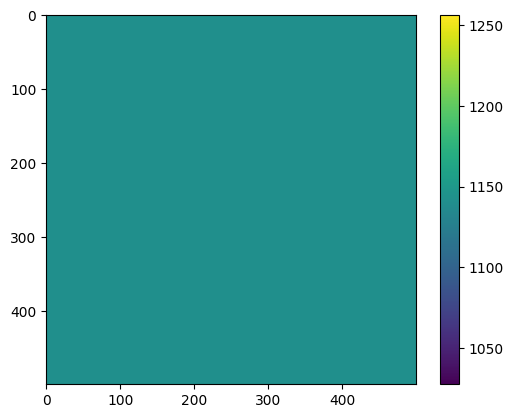

(xˢ=500, yˢ=500) const 0.8999995589256287


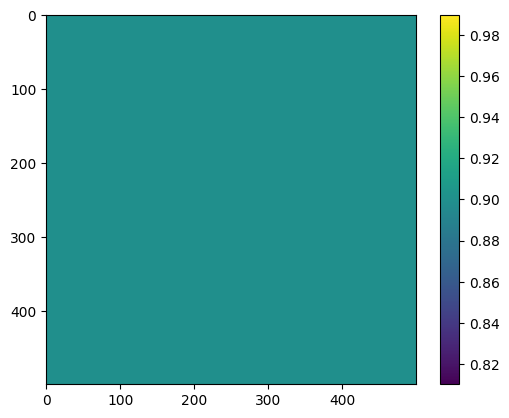

(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)


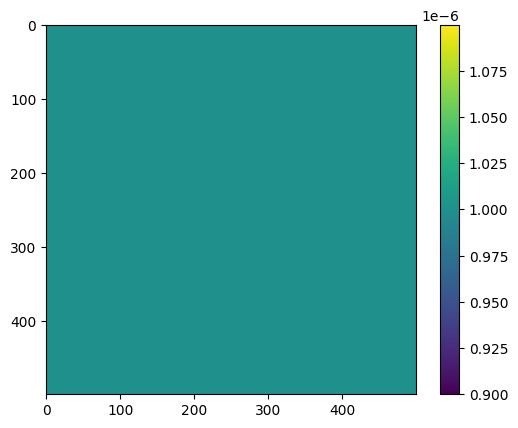

(xˢ=500, yˢ=500) const 1.0000001111620804e-06


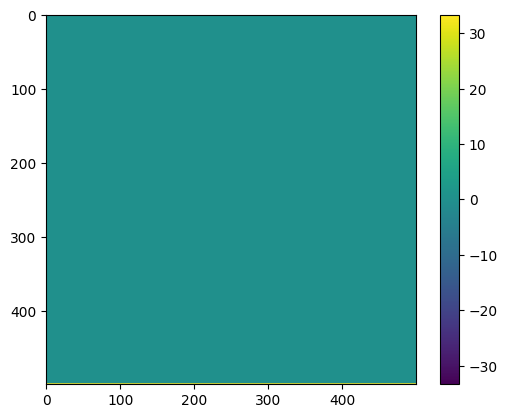

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)


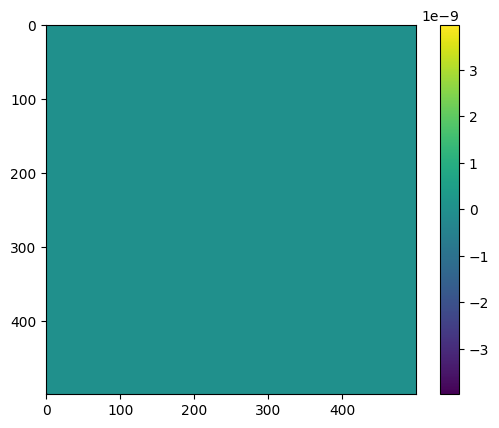

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(xˢ=500, yˢ=500) const 0.8999995589256287
(xˢ=500, yˢ=500) const 0.05000000074505806
(xˢ=500, yˢ=500) const 1.0000001111620804e-06
(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)
(xˢ=500, yˢ=500) -5.23e-05 ± 3.3e-01 (-5e+00...5e+00)


In [ ]:
print(phi[0].sample(geo))
plt.imshow(phi[0].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
print(phi[1].sample(geo))
plt.imshow(phi[1].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
plt.imshow(S_w(phy.compute_p_c(*phi)))
plt.colorbar()
print(S_w(phy.compute_p_c(*phi)))
plt.show()
print(phy.compute_p_c(*phi))
plt.imshow(dsdpc(phy.compute_p_c(*phi)))
plt.colorbar()
plt.show()
print(dsdpc(phy.compute_p_c(*phi)))

plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,0])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,1])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))

print(S_w(phy.compute_p_c(*phi)))
print(K_w_f_t(S_w(phy.compute_p_c(*phi))))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.compute_p_c(*phi))
print(dK_w(phy.compute_p_c(*phi)))
print(K_w(phy.compute_p_c(*phi)))
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(*phi)))
print(dK_o(phy.compute_p_c(*phi)))
#print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(*phi, 1e-5).sample(phi_o.geometry))

In [ ]:
print(phy.dtphi_w_1.sample(geo))

(xˢ=240, yˢ=240) -0.005 ± 4.380 (-5e+01...5e+01)


## NS reesidual

In [ ]:
def incompresibble_fluid_loss(up,xt,mu=1,rho=1):
    l=0
    # x-velocity components
    l+=x_grad(up,xt,0,1)[...,2] # dudt
    l+=torch.sum(up[...,:1]*x_grad(up,xt,0,1)[...,:2],axis=-1) # u * grad u
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,0]) #  dpdx
    l-=(mu/rho)*torch.sum(x_grad(up,xt,0,2)[...,:2],axis=-1) # grad**2 u
    # y-velocity components
    l+=x_grad(up,xt,1,1)[...,2] # dvdt
    l+=torch.sum(up[...,1:2]*x_grad(up,xt,0,1)[...,:2],axis=-1) # v * grad v
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,1]) #  dpdy
    l-=(mu/rho)*torch.sum(x_grad(up,xt,1,2)[...,:2],axis=-1) # grad**2 v
    return l

### Debug

In [ ]:
x1 = torch.randn((3,1,3)).requires_grad_(True)  #
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    ],axis=2)

print(u1.shape)

tensor([[[-1.5316, -0.0218,  1.3527]],

        [[ 2.0246,  0.5625, -0.8633]],

        [[ 0.5488, -0.9313,  0.3730]]], requires_grad=True)
torch.Size([3, 1, 3])
torch.Size([3, 1, 3])


In [ ]:
incompresibble_fluid_loss(u1,x1,1,1)-0
#x_grad(u1,x1,0,1)[...,0]
#print(x1[:,:,:1])
#print(x_grad(u1,x1,0,1)[...,:2])
#x_grad(u1,x1,0,1)[...,2]
#x_grad(u1,x1,0,2)[...,:2]

tensor([[   nan],
        [0.9955],
        [0.3642]], grad_fn=<SubBackward0>)

# reaction diffusion approach

In [2]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK,two_phase_flow_RD
from phi.torch.flow import *
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### example

In [ ]:

@jit_compile
def reaction_diffusion(u, v, du, dv, f, k, dt):
    uvv = u * v**2
    su = du * field.laplace(u) - uvv + f * (1 - u)
    sv = dv * field.laplace(v) + uvv - (f + k) * v
    return u + dt * su, v + dt * sv


def reaction_diffusion(u, v, du, dv, f, k, dt):
    uvv = u * v**2
    su = du * field.laplace(u) - uvv + f * (1 - u)
    sv = dv * field.laplace(v) + uvv - (f + k) * v
    return u + dt * su, v + dt * sv

/tmp/ipykernel_26679/863439274.py:4: DeprecationWarning: phiml.math.length is deprecated in favor of phiml.math.norm
  CenteredGrid(lambda x: math.cos(math.vec_length(x-50)/3), x=100, y=100) * .5,


TypeError: Image data of dtype object cannot be converted to float

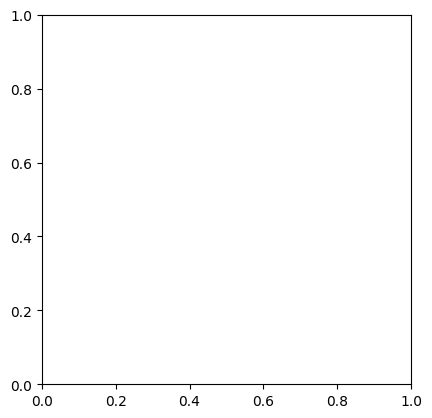

In [6]:
u0 = [
    CenteredGrid(Noise(scale=20, smoothness=1.3), x=100, y=100) * .2 + .1,
    CenteredGrid(lambda x: math.exp(-0.5 * math.sum((x - 50)**2) / 3**2), x=100, y=100),
    CenteredGrid(lambda x: math.cos(math.vec_length(x-50)/3), x=100, y=100) * .5,
]
u0 = stack(u0, batch('initialization'))
plt.imshow(u0)

In [ ]:
maze = {'du': 0.19, 'dv': 0.05, 'f': 0.06, 'k': 0.062}
u_trj, v_trj = iterate(reaction_diffusion, batch(time=100), u0, u0, dt=.5, f_kwargs=maze, substeps=20)


RuntimeError: No user interface available.

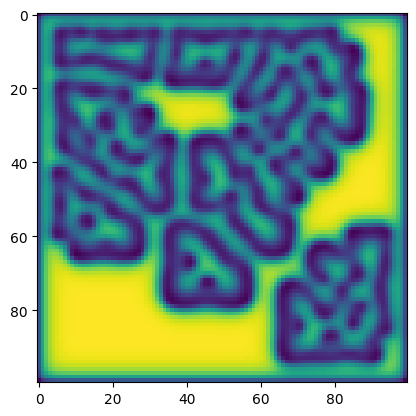

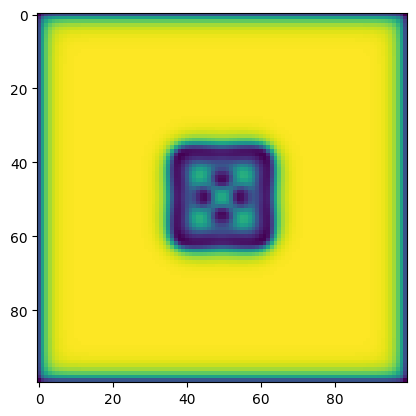

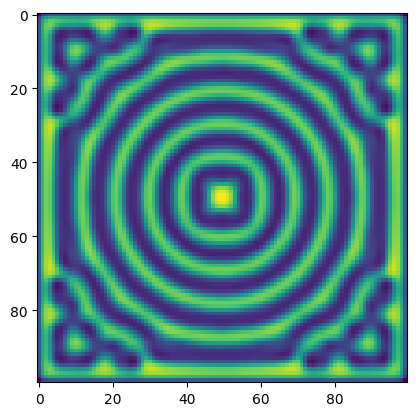

In [17]:

time=50
plt.imshow(u_trj.initialization[0].time[time].values)
plt.show()
plt.imshow(u_trj.initialization[1].time[time].values)
plt.show()
plt.imshow(u_trj.initialization[2].time[time].values)
plt.show()

### 2 phase flow with saturation dependent permeability

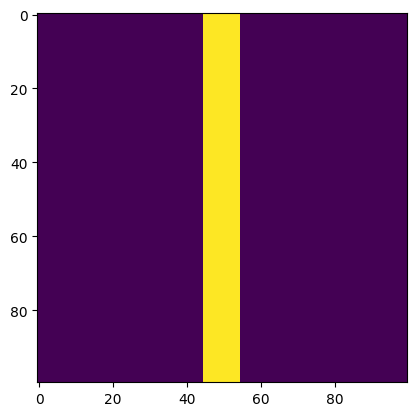

In [366]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from copy import deepcopy
from scipy import ndimage

Sw_args={
    "SWR":0.05,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })

SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Pc_=sympy.symbols("P_c")

Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)

Sw_Pc=(1-SWC-SOR)*((Pc_/Pi)**(-1*lam))+SWC
dScdPc=sympy.diff(Sw_Pc,Pc_)


K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))

#Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,0.05,0.45,0.5,1e5)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
Se_f=lambda sw: sympy.lambdify((Sw,SOR,SWC),Sc)(sw,*tuple(Sw_args.values()))
K_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),K_rw)(sw,*tuple(Pc_args.values()),0.3)
K_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),K_ro)(sw,*tuple(Pc_args.values()),0.5)

K_w_f_t=lambda sw: 1000.0 * 9.869233e-13
K_o_f_t=lambda sw: 1000.0 * 9.869233e-13

K_s=np.ones((100,100))*1e2
K_s[:,45:55]=1e3
plt.imshow(K_s)
#K_s=ndimage.zoom(K_s,(0.3,0.3)) * 9.869233e-13


dK_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),sympy.diff(K_rw,Sw))(sw,*tuple(Pc_args.values()),0.3)
dK_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),sympy.diff(K_ro,Sw))(sw,*tuple(Pc_args.values()),0.5)

Sw_Pc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),Sw_Pc)(sw,*tuple(Pc_args.values()))
dScdPc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),dScdPc)(sw,*tuple(Pc_args.values()))

from phi.torch.flow import math  #,Field, unstack,stack,batch,field,vec

MUO=1.295
MUW=0.32

K_w=lambda K_l,p_c:stack(
    [stack([K_l*K_rw_f(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_l*K_rw_f(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c))],batch("k") )],batch("KK"))

K_o=lambda K_l,p_c:stack(
    [stack([K_l*K_ro_f(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_l*K_ro_f(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c))],batch("k") )],batch("KK"))

dK_w=lambda K_l,p_c:stack(
    [stack([K_l*dK_rw_f(Sw_Pc_f(p_c))/(MUW),math.zeros_like(p_c)],batch("dk") ),
    stack([math.zeros_like(p_c),K_l*dK_rw_f(Sw_Pc_f(p_c))/(MUW)],batch("dk") )],batch("dKK"))

dK_o=lambda K_l,p_c:stack(
    [stack([K_l*dK_ro_f(Sw_Pc_f(p_c))/(MUO),math.zeros_like(p_c)],batch("dk") ),
    stack([math.zeros_like(p_c),K_l*dK_ro_f(Sw_Pc_f(p_c))/(MUO)],batch("dk") )],batch("dKK"))

grad_phi_dK = lambda phi_a,dK_a:(math.dot(
    field.spatial_gradient(phi_a,phi_a.boundary).sample(phi_a.geometry),"vector",

    dK_a,"dKK"))

In [ ]:
from phiml.math import sum as phi_sum
from phiml import math as pmath

K_s=ndimage.zoom(K_s,(0.6,0.6)) * 9.869233e-13

class two_phase_flow_RD(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver
    self.K_o=K_o
    self.K_w=K_w
    self.K_l=K_s


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    p_c=pmath.clip(p_c,lower_limit=Pc_f(0.80),upper_limit=Pc_f(0.05))
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(phi_a,phi_b)
    convective_velocity = grad_phi_dK(phi_a,dK_a(self.K_l,p_c))\
                         - grad_phi_dK(phi_b,dK_b(self.K_l,p_c))

    print("in convective_velocity")
    print(convective_velocity)
    print("dK_a(self.K_l,p_c)")
    print(dK_a(self.K_l,p_c))
    print("dK_b(self.K_l,p_c)")
    print(dK_b(self.K_l,p_c))
    print("p_c")
    print(p_c)
    print("Sw_pc")
    print(Sw_Pc_f(p_c))
    print("dK_ro_f(Sw_Pc_f(p_c))")
    print(dK_ro_f(Sw_Pc_f(p_c)))
    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    p_c=self.compute_p_c(phi_w,phi_o)

    w_advection_term = phi_sum(self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_w.gradient(),"vector").sample(phi_w.geometry)

    x,y=unstack(phi_sum(self.K_o(self.K_l,p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (self.dtphi_o_1)

    return phi_w + dt * (phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) - phi_w.with_values(w_diffusion_term))
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    p_c=self.compute_p_c(phi_w,phi_o)

    w_advection_term = phi_sum(self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_o.gradient(),"vector").sample(phi_o.geometry)

    x,y=unstack(phi_sum(self.K_w(self.K_l,p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (self.dtphi_w_1)

    return phi_o + dt * (phi_o.with_values(pressure_chage_term) + phi_o.with_values(w_advection_term) - phi_o.with_values(w_diffusion_term))
  
  def phi_w_pde(self,phi_w,phi_o,dtphi_o):
    p_c=self.compute_p_c(phi_w,phi_o)
    
    w_advection_term = phi_sum(
      self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_w)*phi_w.gradient(),
      "vector").sample(phi_w.geometry)
    
    x,y=unstack(phi_sum(self.K_w(self.K_l,p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (dtphi_o.values)
    return phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) - phi_w.with_values(w_diffusion_term)
  
  def phi_o_pde(self,phi_o,phi_w,dtphi_w):
    p_c=self.compute_p_c(phi_w,phi_o)
    
    w_advection_term = phi_sum(
      self.compute_convective_velocity(phi_w,phi_o,dK_o,dK_o)*phi_o.gradient(),
      "vector").sample(phi_o.geometry)
    
    x,y=unstack(phi_sum(self.K_o(self.K_l,p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_o.gradient(2)*spatial_diffusion,"vector"))

    pressure_chage_term = (dtphi_w.values)
    return phi_o.with_values(pressure_chage_term) + phi_o.with_values(w_advection_term) - phi_o.with_values(w_diffusion_term)
  
  def RK4(self,phi_w,phi_o,dt):

    print("paso 1")
    K_o1=self.phi_o_pde(phi_o,phi_w,self.dtphi_w_1)
    K_w1=self.phi_w_pde(phi_w,phi_o,self.dtphi_o_1)

    print("paso 2")
    K_o2=self.phi_o_pde(phi_o+0.5*K_o1.values*dt,phi_w+0.5*K_w1.values*dt,K_w1)
    K_w2=self.phi_w_pde(phi_w+0.5*K_w1.values*dt,phi_o+0.5*K_o1.values*dt,K_o1)

    print("paso 3")
    K_o3=self.phi_o_pde(phi_o+0.5*K_o2.values*dt,phi_w+0.5*K_w2.values*dt,K_w2)
    K_w3=self.phi_w_pde(phi_w+0.5*K_w2.values*dt,phi_o+0.5*K_o2.values*dt,K_o2)

    print("paso 4")
    K_o4=self.phi_o_pde(phi_o+K_o3.values*dt,phi_w+K_w3.values*dt,K_w3)
    K_w4=self.phi_w_pde(phi_w+K_w3.values*dt,phi_o+K_o3.values*dt,K_o3)

    self.dtphi_o_1 = (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    self.dtphi_w_1 = (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)

    phi_o = phi_o.with_values(pmath.clip(phi_o.values + dt * (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4).values,lower_limit=0.0,upper_limit=1e9))
    phi_w = phi_w.with_values(pmath.clip(phi_w.values + dt * (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4).values,lower_limit=0.0,upper_limit=phi_o.values))
    return phi_w,phi_o
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = self.phi_w_momentum_eq(phi_w,phi_o, dt)
    new_phi_o = self.phi_o_momentum_eq(phi_o,phi_w, dt)
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [379]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *


p_o=Pc_f(0.05)

geo=UniformGrid(x=60, y=60,bounds=Box(x=6e3, y=6e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':1e4,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 1e4,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phy=two_phase_flow_RD(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    #w_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v),
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    #o_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v)
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
)

#from Differentiable_simulation import K_o_f_t,K_w_f_t,S_w,dK_o,dK_w,dK_o,dsdpc

print(phy.compute_p_c(phi_w,phi_o))
print(Sw_Pc_f(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(Sw_Pc_f(phy.compute_p_c(phi_w,phi_o))))
print(dScdPc_f(phy.compute_p_c(phi_w,phi_o)))
print(K_w(K_s,phy.compute_p_c(phi_w,phi_o)))
print(K_o(K_s,phy.compute_p_c(phi_w,phi_o)))
print(dK_o(K_s,phy.compute_p_c(phi_w,phi_o)))
print(dK_w(K_s,phy.compute_p_c(phi_w,phi_o)))

print(grad_phi_dK(phi_o,dK_o(K_s,phy.compute_p_c(phi_w,phi_o))))
print(grad_phi_dK(phi_w,dK_w(K_s,phy.compute_p_c(phi_w,phi_o))))

(xˢ=60, yˢ=60) const 25000.0
(xˢ=60, yˢ=60) const 0.3500000238418579
9.869233000000002e-10
(xˢ=60, yˢ=60) const -3.000000106112566e-06
(KKᵇ=2, kᵇ=2, xˢ=60, yˢ=60) -3.75e-10 ± 8.7e-10 (-4e-09...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=60, yˢ=60) -7.71e-06 ± 1.8e-05 (-9e-05...0e+00)


/tmp/ipykernel_13469/2846616084.py:64: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  [stack([K_l*K_rw_f(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
/tmp/ipykernel_13469/2846616084.py:65: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  stack([math.zeros_like(p_c),K_l*K_rw_f(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c))],batch("k") )],batch("KK"))
/tmp/ipykernel_13469/2846616084.py:68: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first.

(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
(dkᵇ=2, xˢ=60, yˢ=60) 6.45e-11 ± 1.3e-09 (0e+00...4e-08)
(dkᵇ=2, xˢ=60, yˢ=60) -4.37e-14 ± 8.5e-13 (-3e-11...0e+00)


In [ ]:
#phi_t=[]
#phi=(phi_w,phi_o)
#phi_t.append(phi)
#for i in range(50):
#    phi=phy.implicit_time_step(*phi,1e-1)
#    phi_t.append(phi)


phi_t=[]
phi=(phi_w,phi_o)
phi_t.append(phi)
for i in range(500):
    print(i)
    
    phi=phy.RK4(*phi,1e5)
    #phi=phy.implicit_time_step(*phi,1e5)
    phi_t.append(phi)
    
    if np.isnan(np.sum(phy.compute_p_c(*phi).numpy("x,y"))):
        print("nan")
        print(i)
        break

0
paso 1
in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) const 0.0
dK_a(self.K_l,p_c)


/tmp/ipykernel_13469/2846616084.py:76: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  [stack([K_l*dK_ro_f(Sw_Pc_f(p_c))/(MUO),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_13469/2846616084.py:77: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  stack([math.zeros_like(p_c),K_l*dK_ro_f(Sw_Pc_f(p_c))/(MUO)],batch("dk") )],batch("dKK"))


(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025


/tmp/ipykernel_13469/2846616084.py:68: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  [stack([K_l*K_ro_f(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
/tmp/ipykernel_13469/2846616084.py:69: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  stack([math.zeros_like(p_c),K_l*K_ro_f(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c))],batch("k") )],batch("KK"))
/tmp/ipykernel_13469/2846616084.py:72: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first.

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) const 0.0
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
paso 2


/tmp/ipykernel_13469/2846616084.py:64: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  [stack([K_l*K_rw_f(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
/tmp/ipykernel_13469/2846616084.py:65: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  stack([math.zeros_like(p_c),K_l*K_rw_f(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c))],batch("k") )],batch("KK"))


in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) 7.94e-13 ± 3.0e-11 (-9e-10...1e-09)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) 2.50e+04 ± 8.9e+00 (2e+04...2e+04)
Sw_pc
(xˢ=60, yˢ=60) 3.50e-01 ± 2.7e-05 (4e-01...4e-01)
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) -1.07e+00 ± 4.6e-05 (-1e+00...-1e+00)
in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -5.38e-16 ± 2.0e-14 (-7e-13...6e-13)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.25e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.25e-14 ± 1.2e-13 (0e+00...6e-13)
p_c
(xˢ=60, yˢ=60) 2.50e+04 ± 8.9e+00 (2e+04...2e+04)
Sw_pc
(xˢ=60, yˢ=60) 3.50e-01 ± 2.7e-05 (4e-01...4e-01)
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) -1.07e+00 ± 4.6e-05 (-1e+00...-1e+00)
paso 3
in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -5.81e-15 ± 1.0e-12 (-4e-11...2e-11)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=

In [336]:
pmath.max(phi_o.values)

25000.0

/tmp/ipykernel_13469/2846616084.py:72: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  [stack([K_l*dK_rw_f(Sw_Pc_f(p_c))/(MUW),math.zeros_like(p_c)],batch("dk") ),
/tmp/ipykernel_13469/2846616084.py:73: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (xˢ=60, yˢ=60)
  stack([math.zeros_like(p_c),K_l*dK_rw_f(Sw_Pc_f(p_c))/(MUW)],batch("dk") )],batch("dKK"))
/tmp/ipykernel_13469/2846616084.py:76: SyntaxWarning: Combining a phiml.math.Tensor with a <class 'numpy.ndarray'> of same shape is not invariant under shape permutations. Please convert the <class 'numpy.ndarray'> to a phiml.math.Tensor first. Shapes: (60, 60) and (

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
0


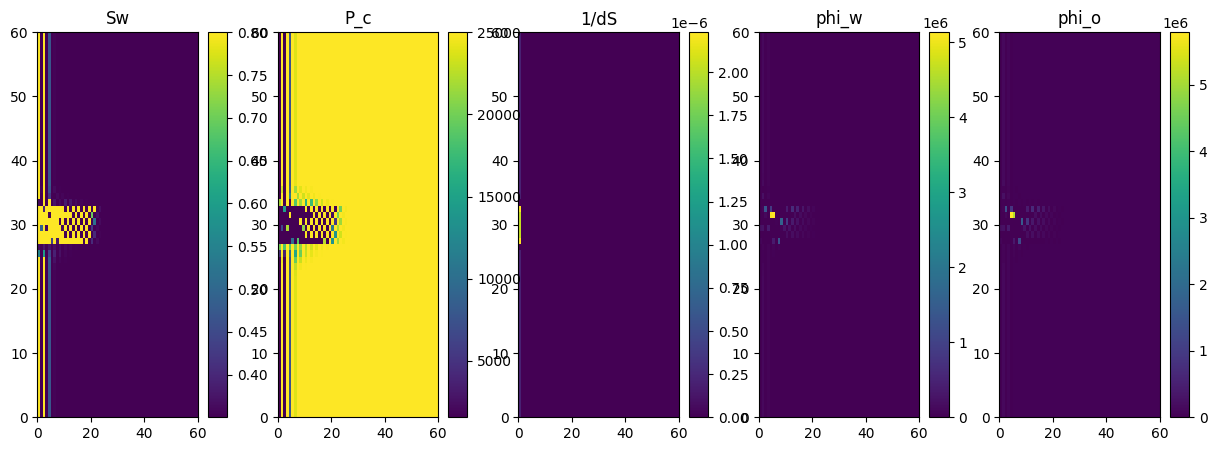

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
1


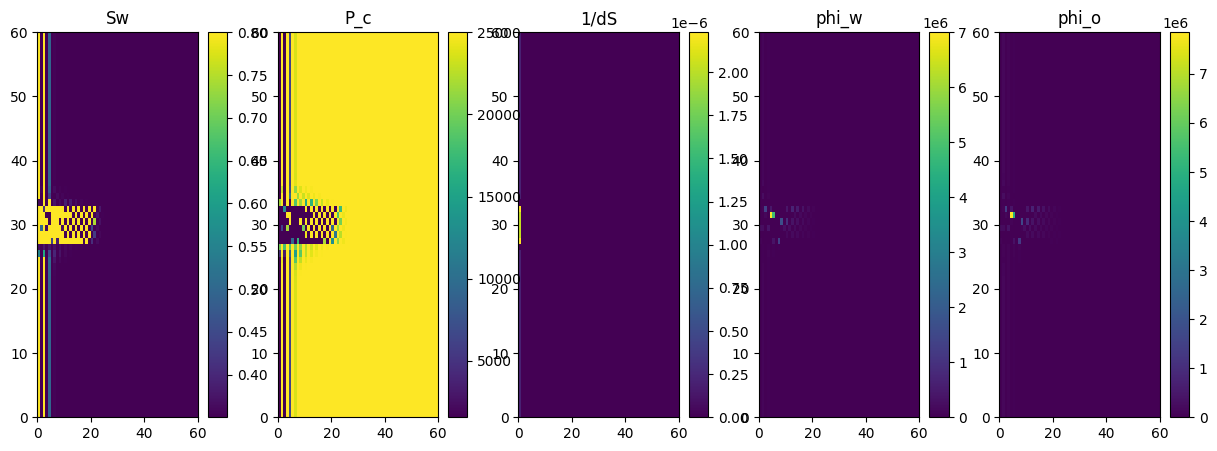

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
2


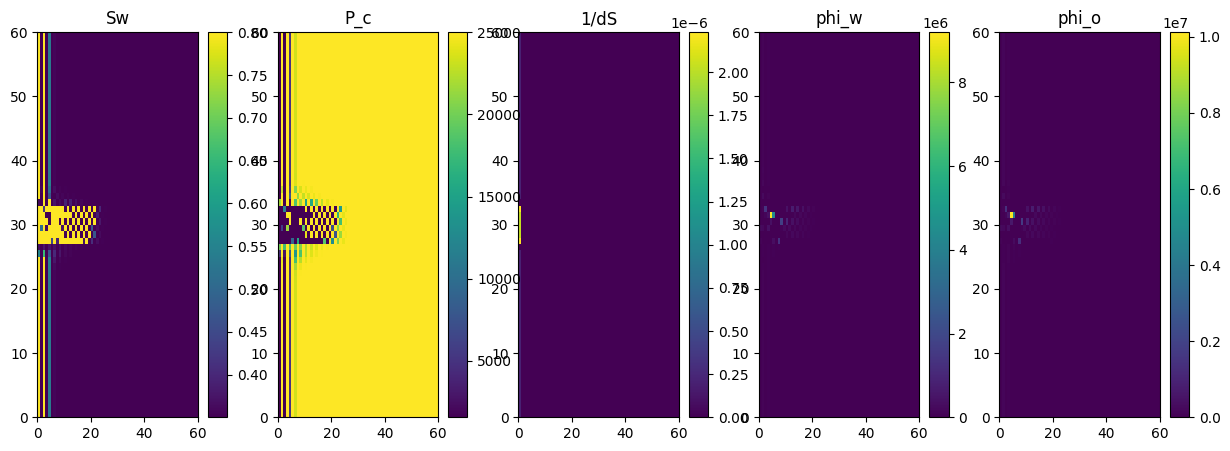

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
3


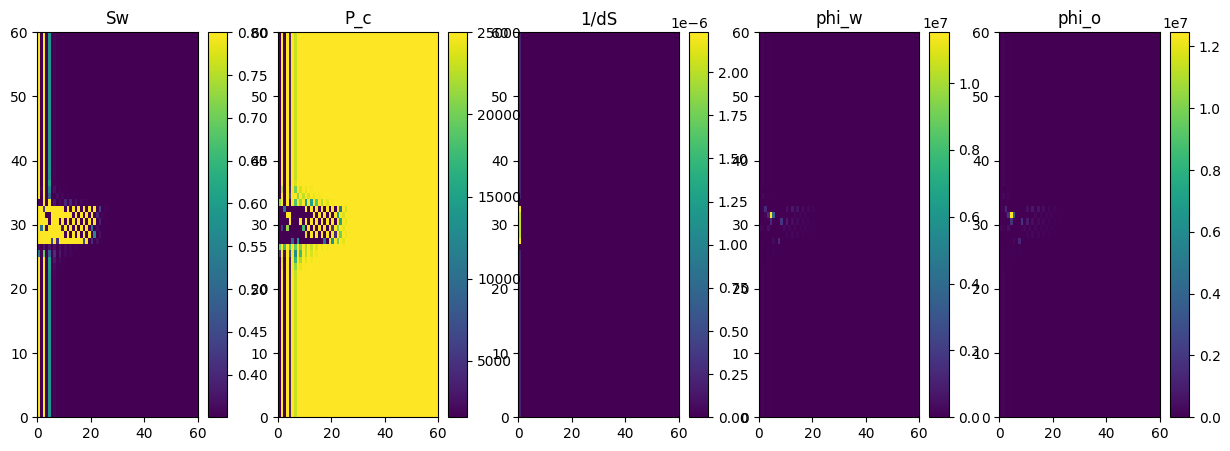

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
4


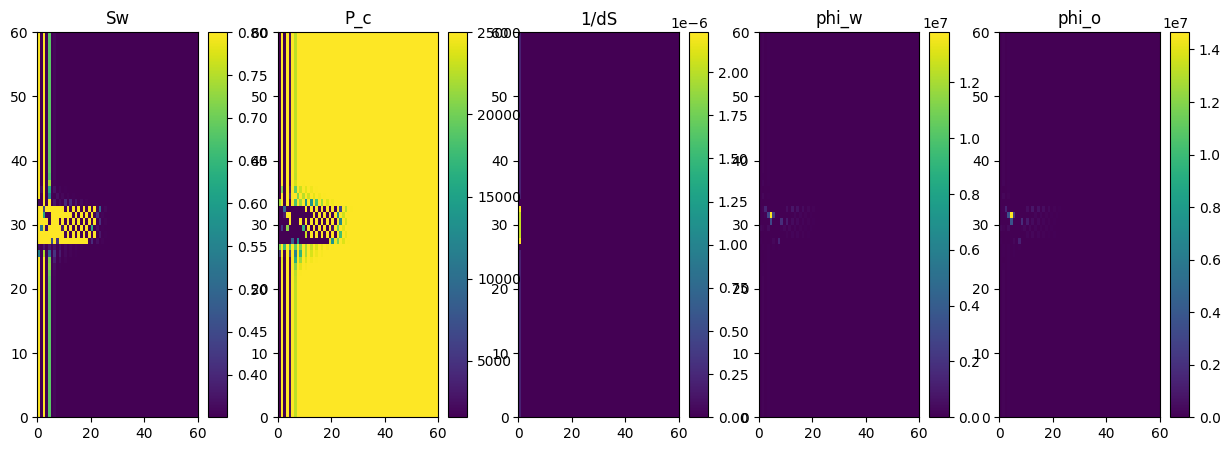

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
5


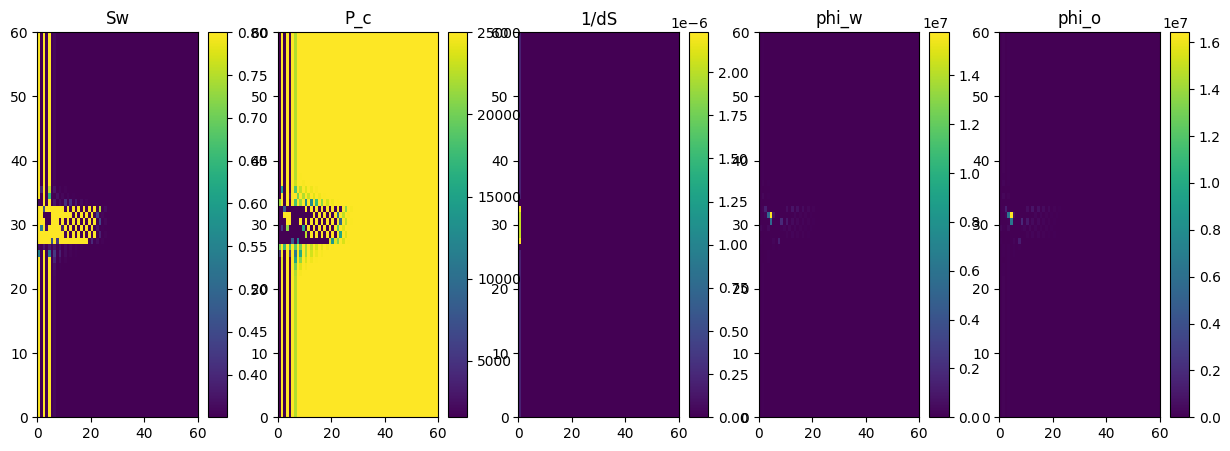

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
6


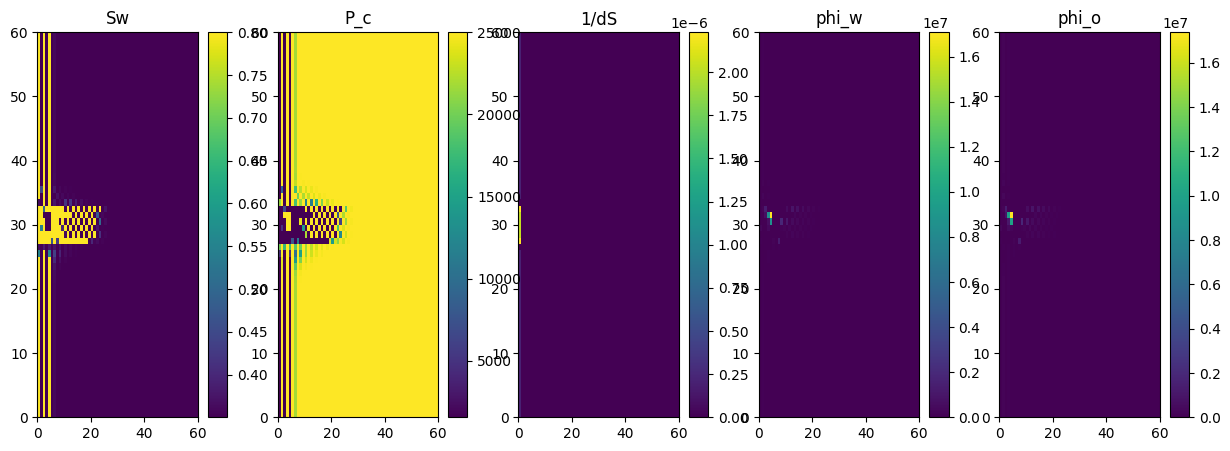

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
7


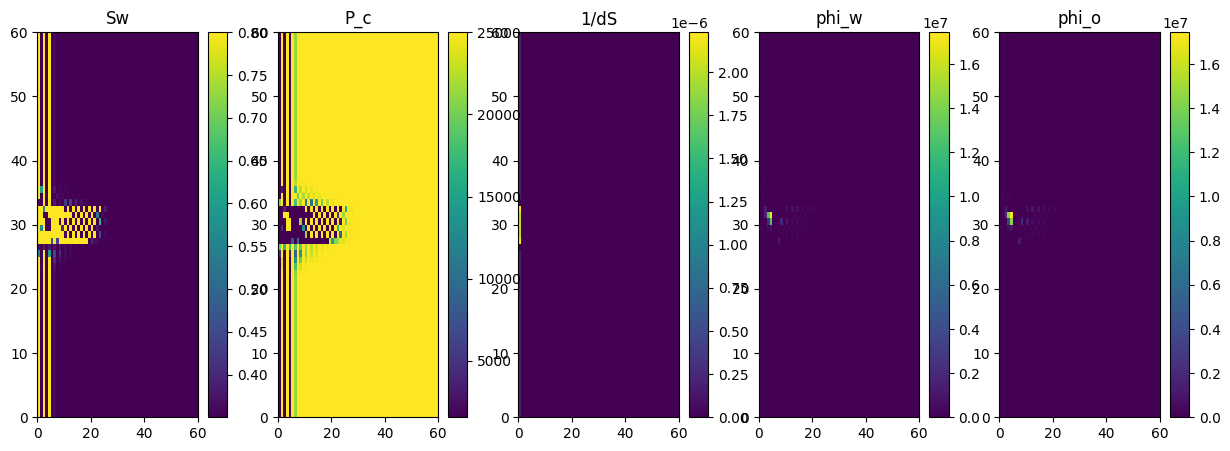

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
8


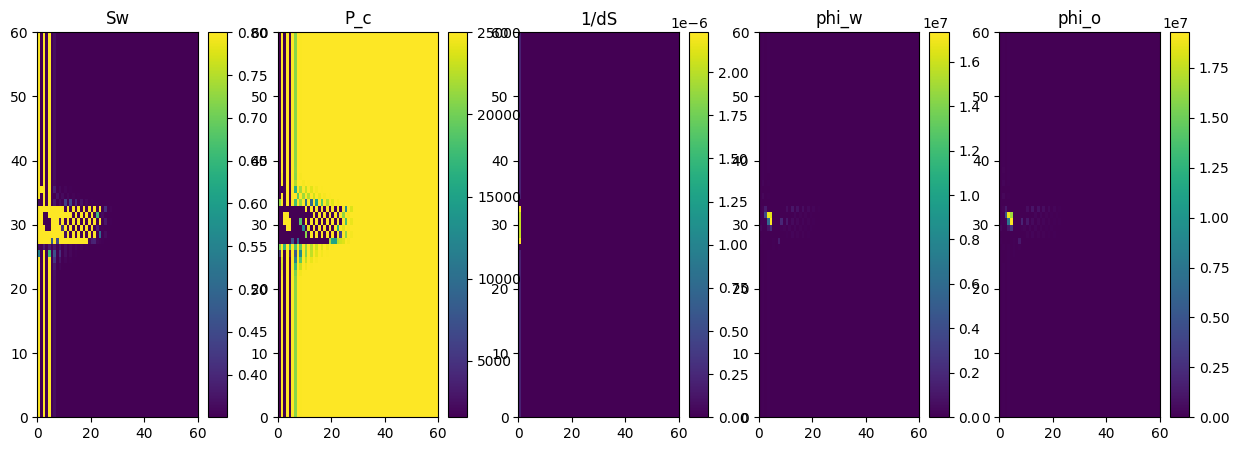

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
9


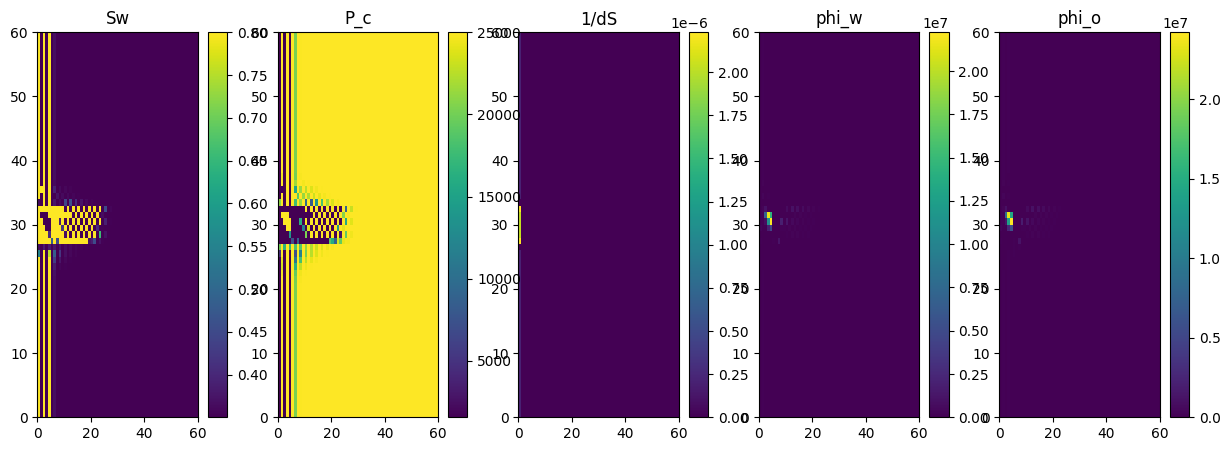

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
10


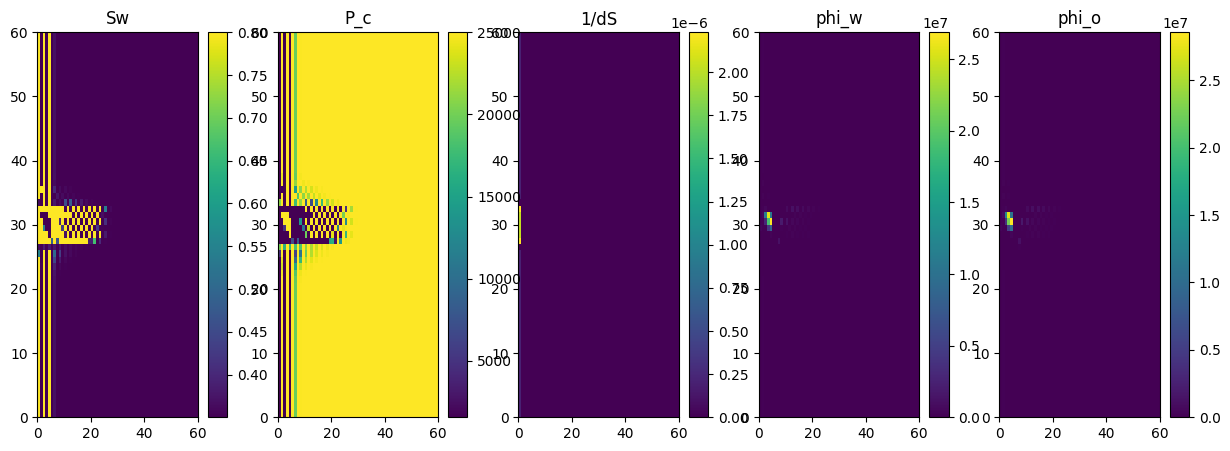

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
11


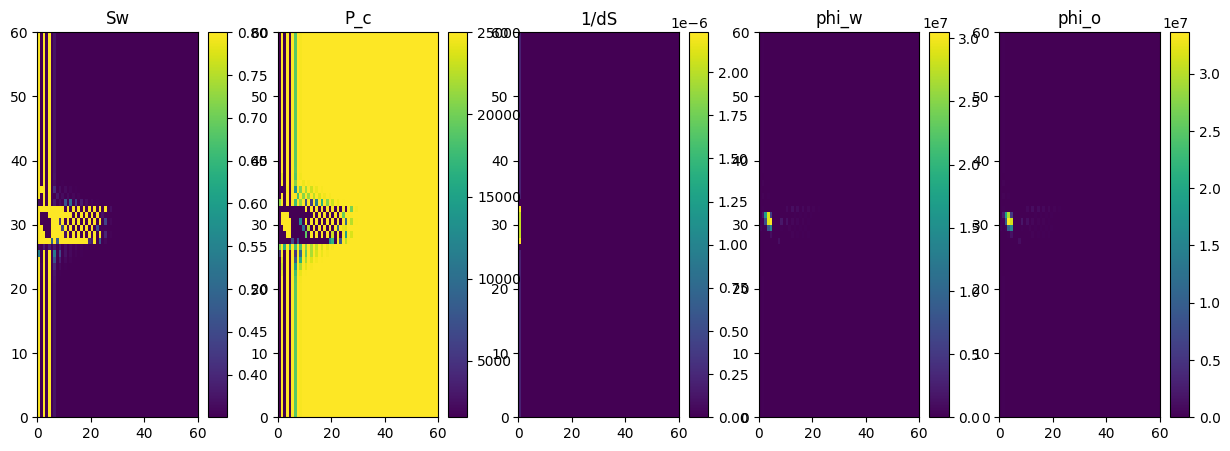

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
12


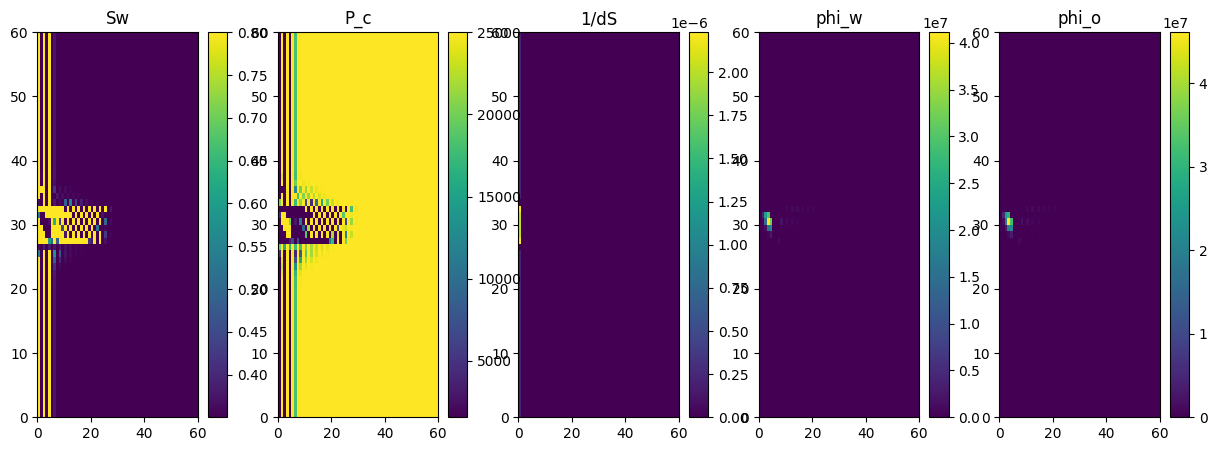

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
13


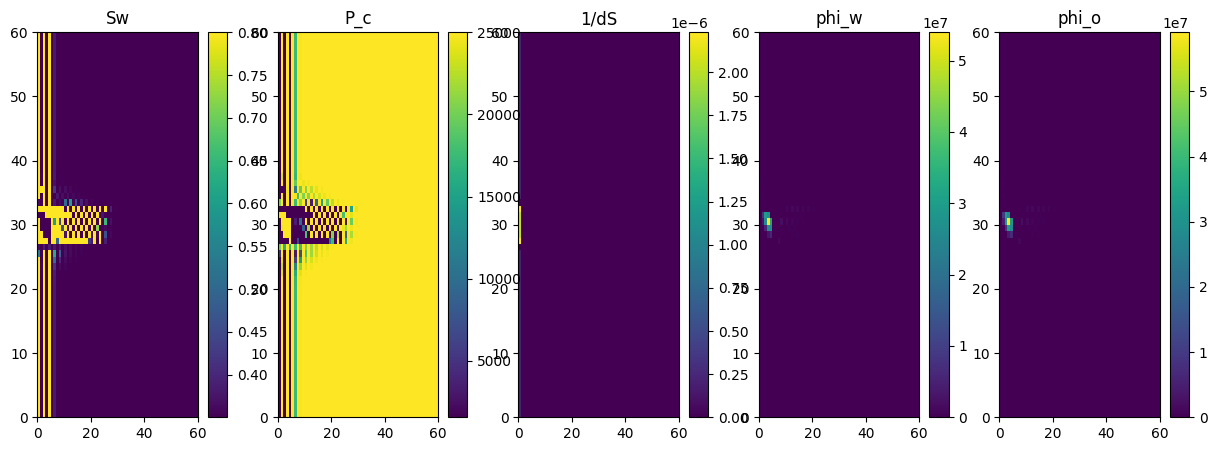

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
14


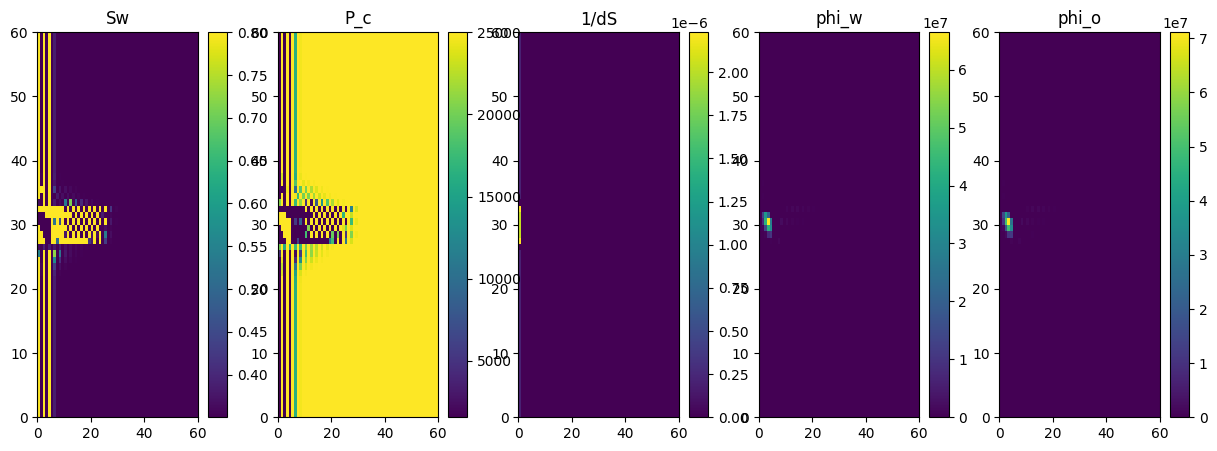

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
15


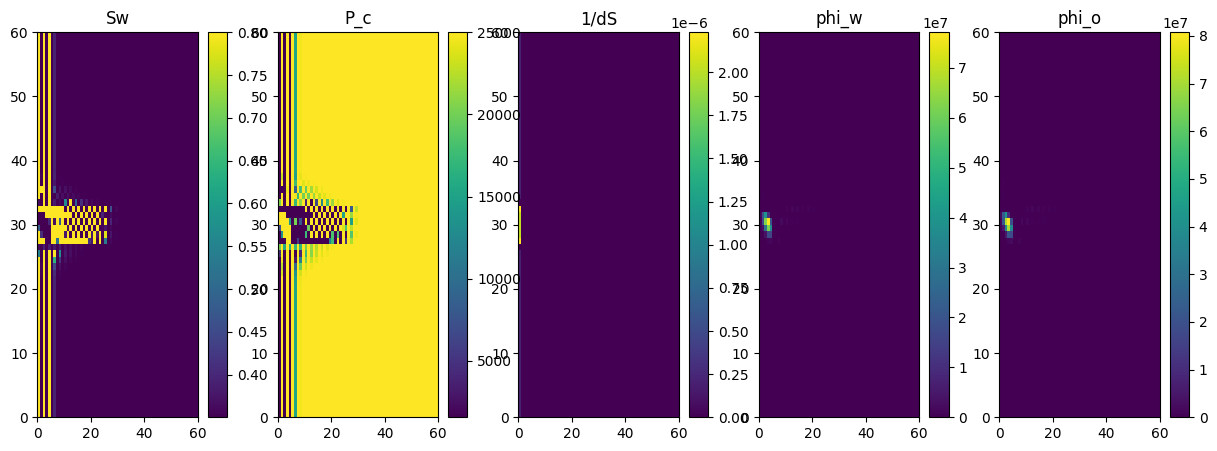

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
16


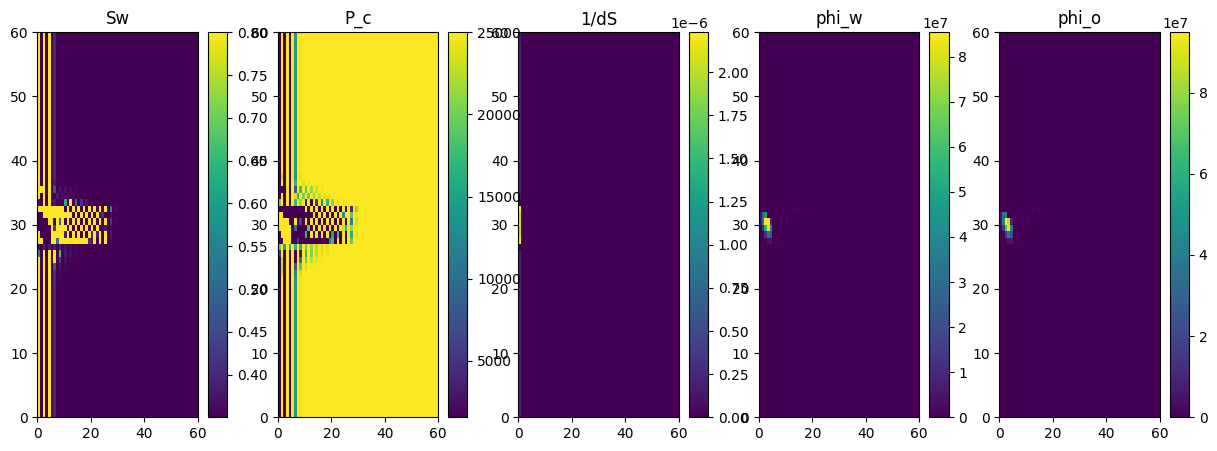

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
17


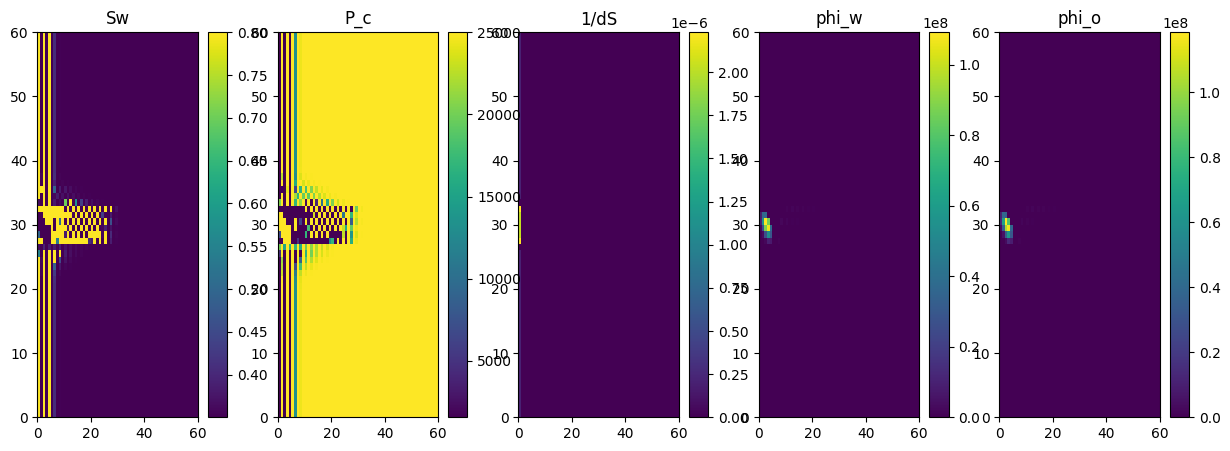

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
18


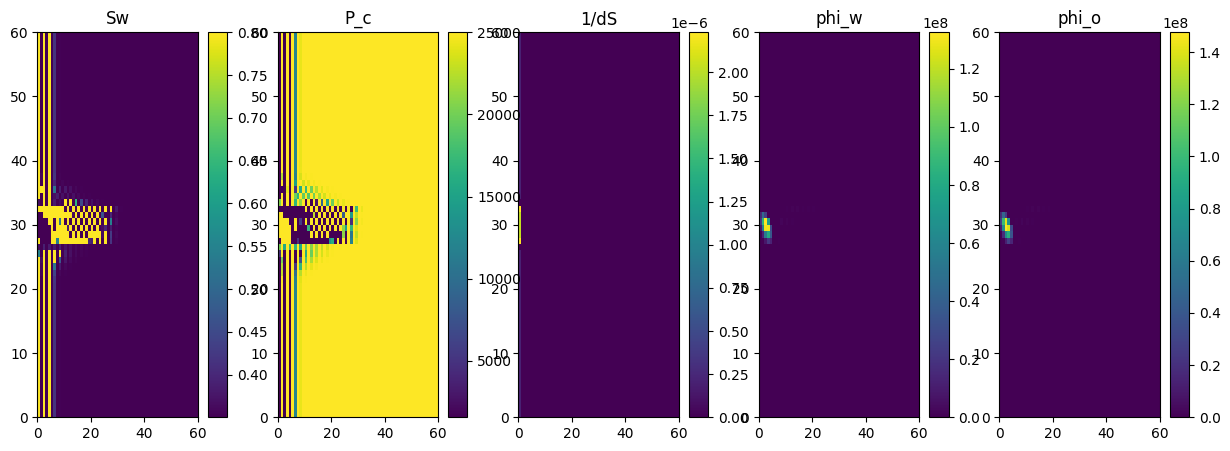

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
19


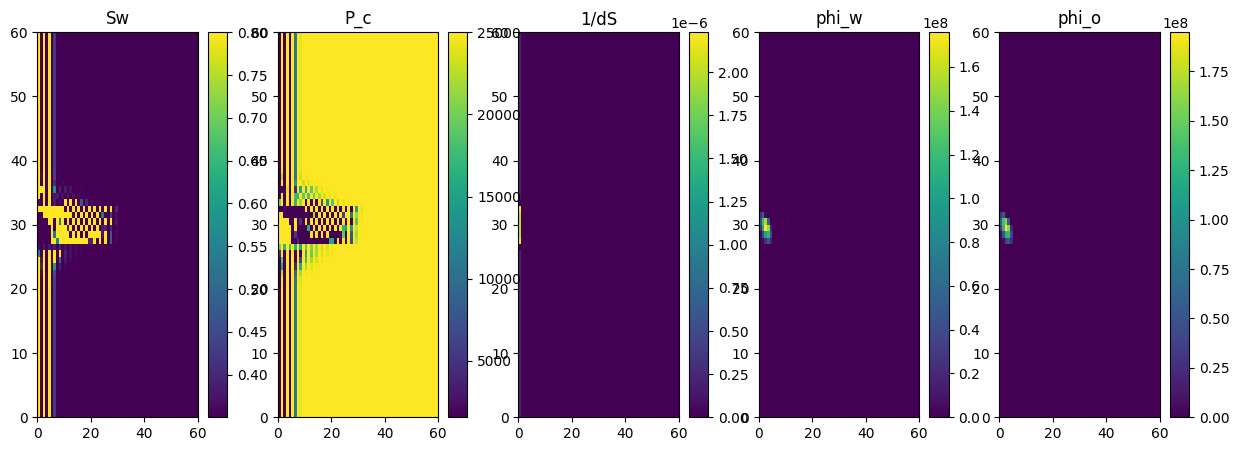

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
20


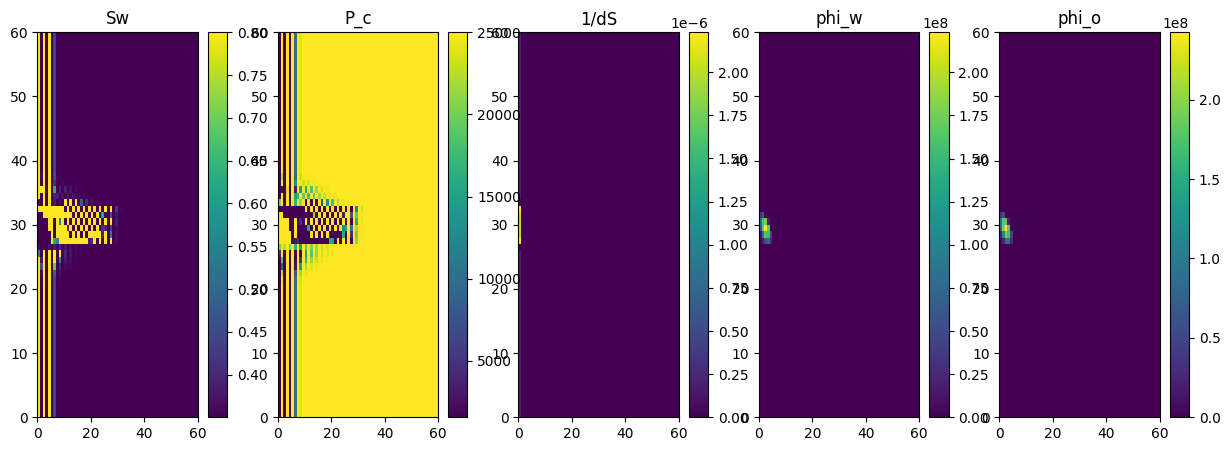

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
21


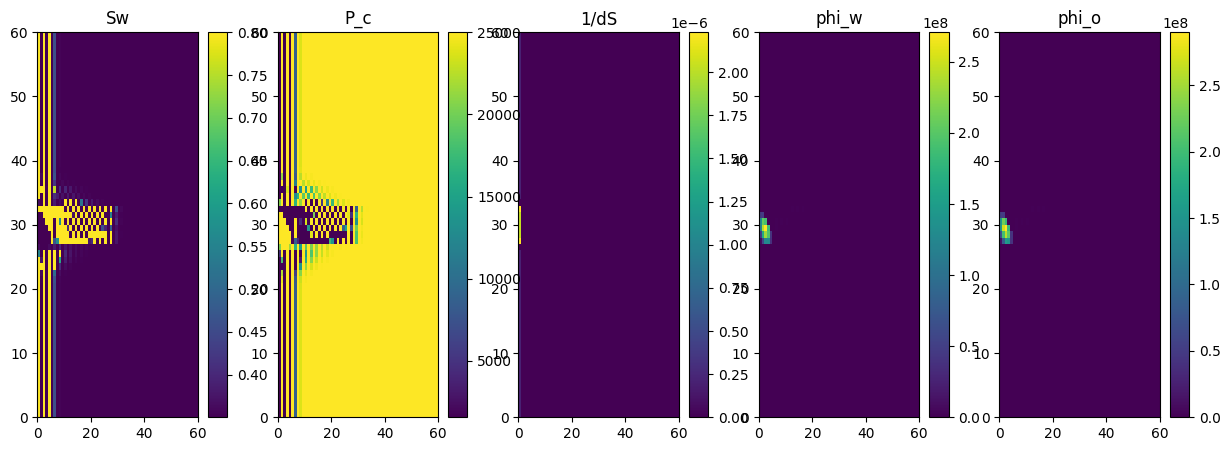

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
22


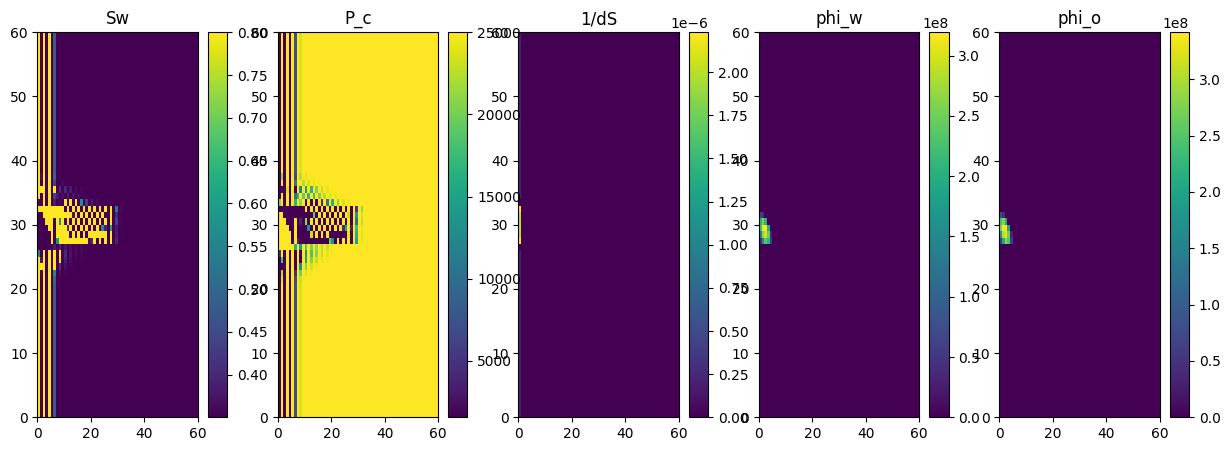

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
23


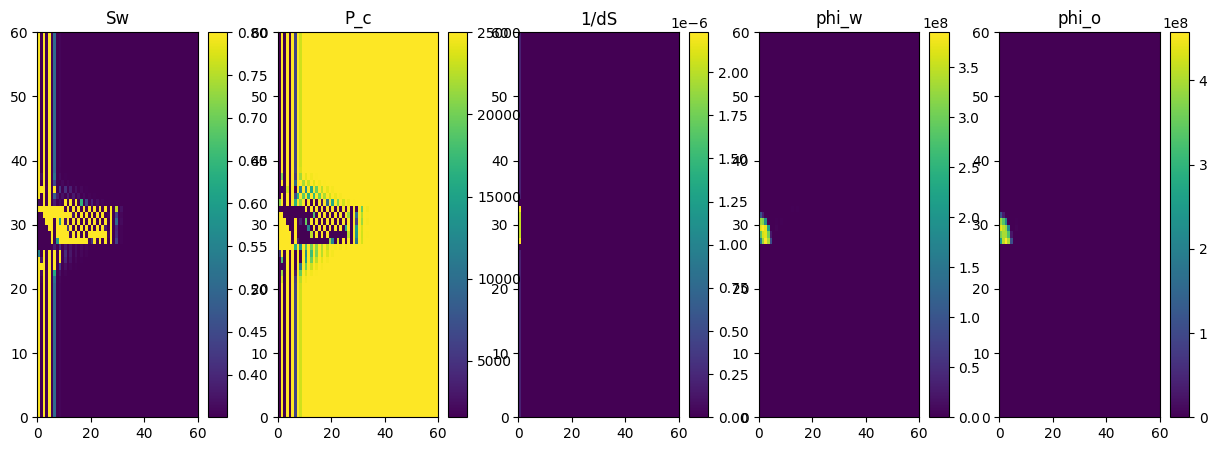

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
24


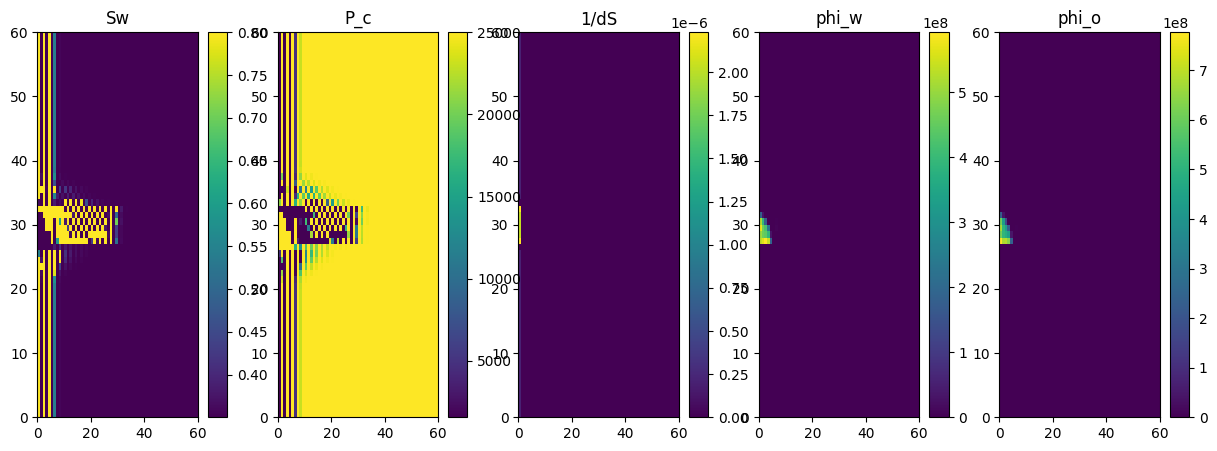

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
25


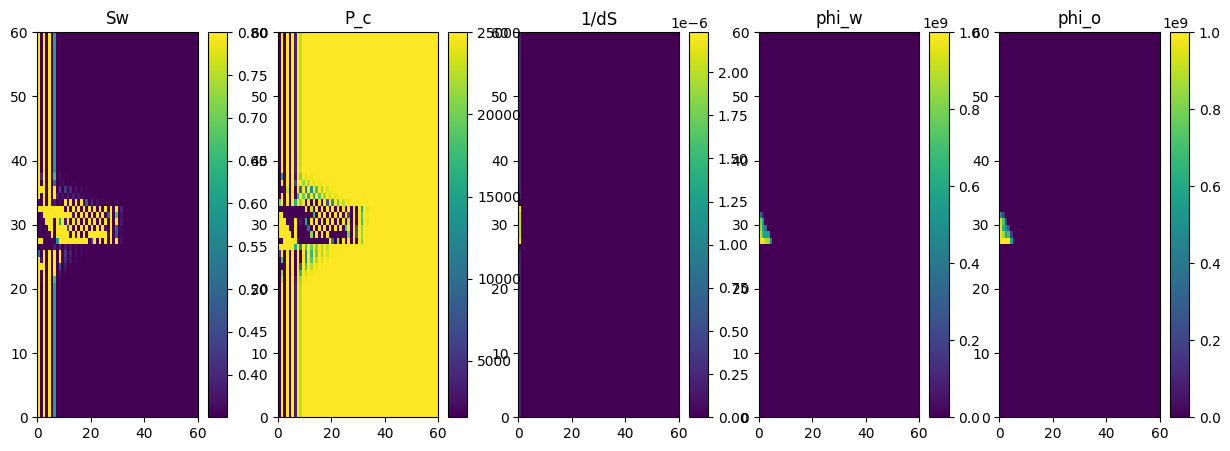

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
26


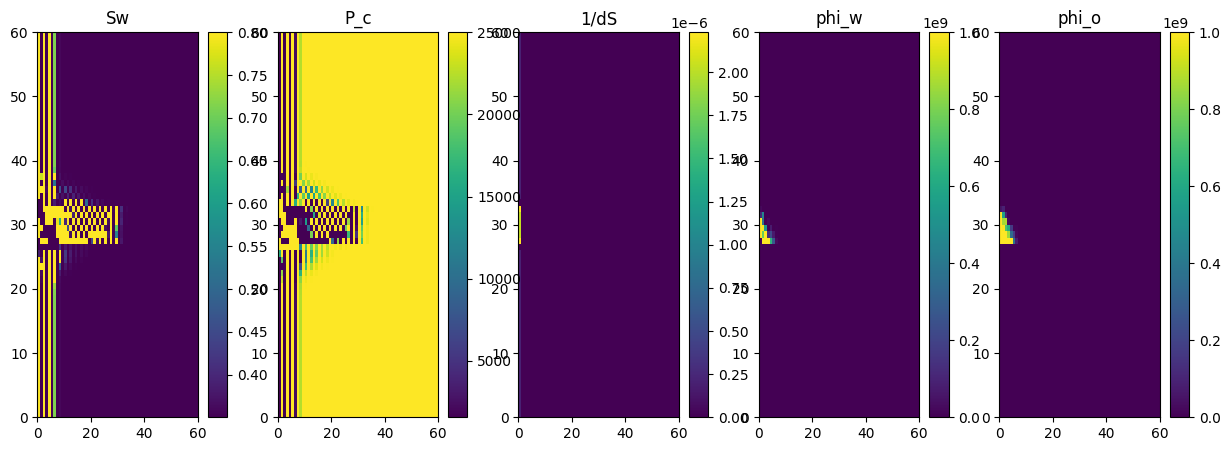

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
27


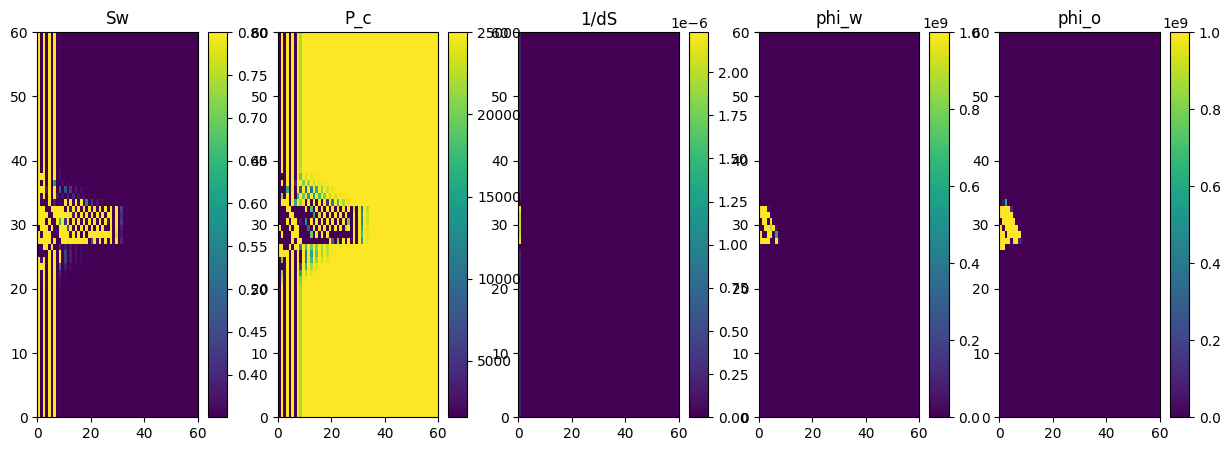

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
28


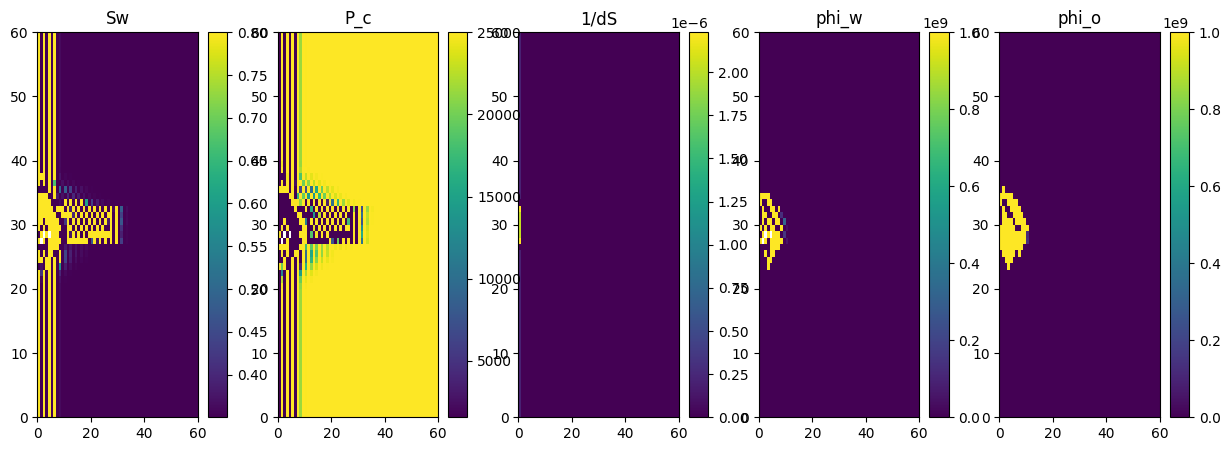

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
29


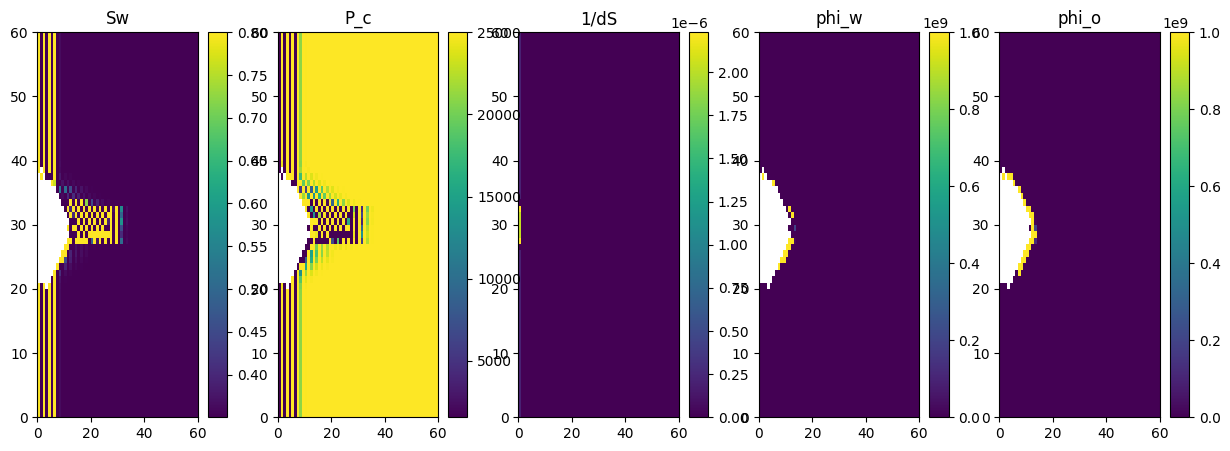

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
30


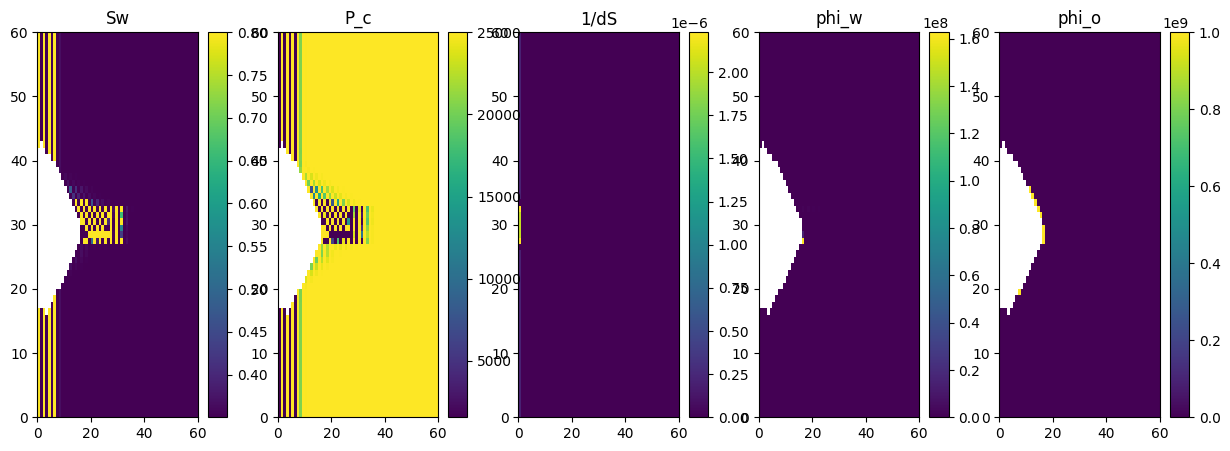

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
31


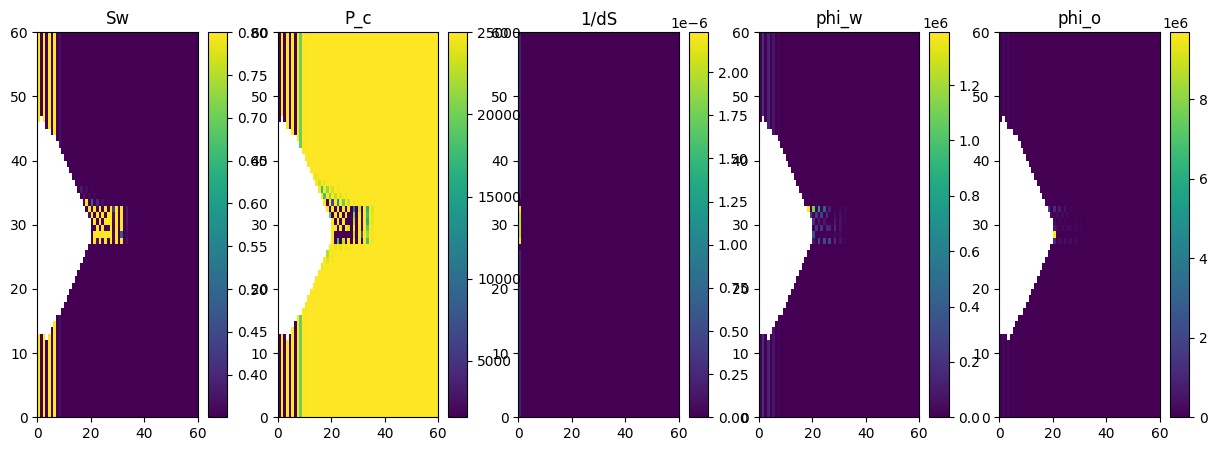

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
32


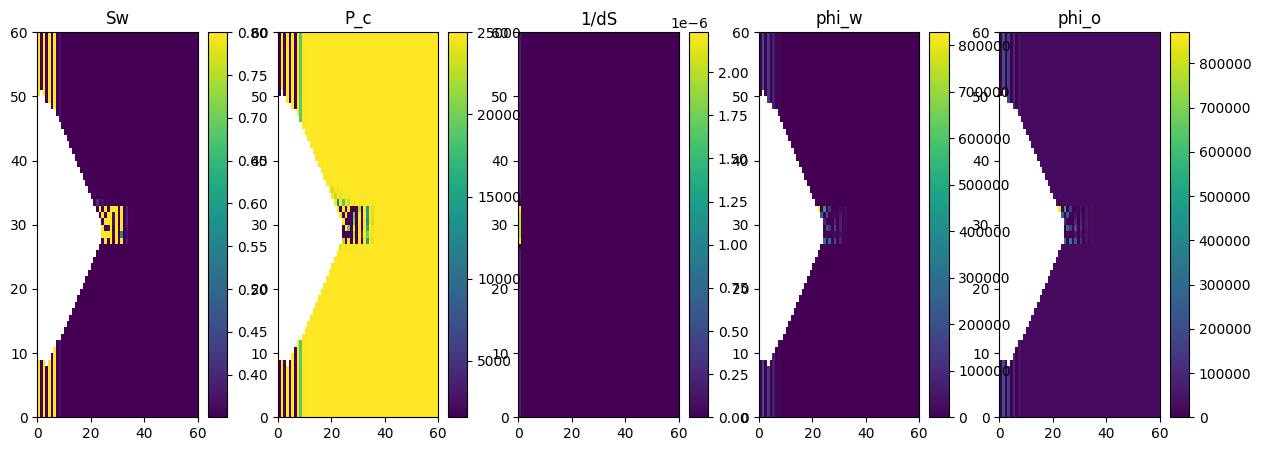

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
33


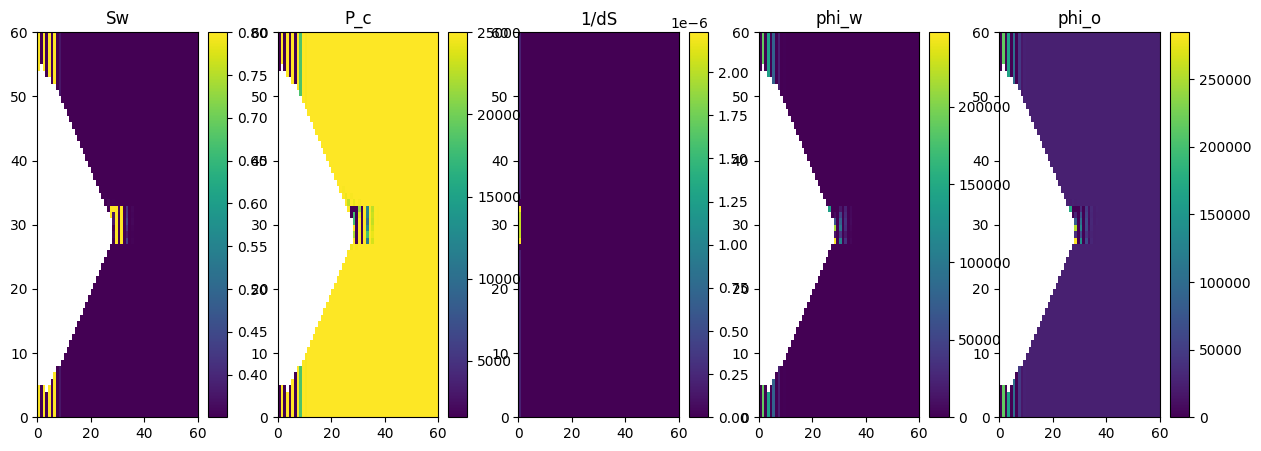

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
34


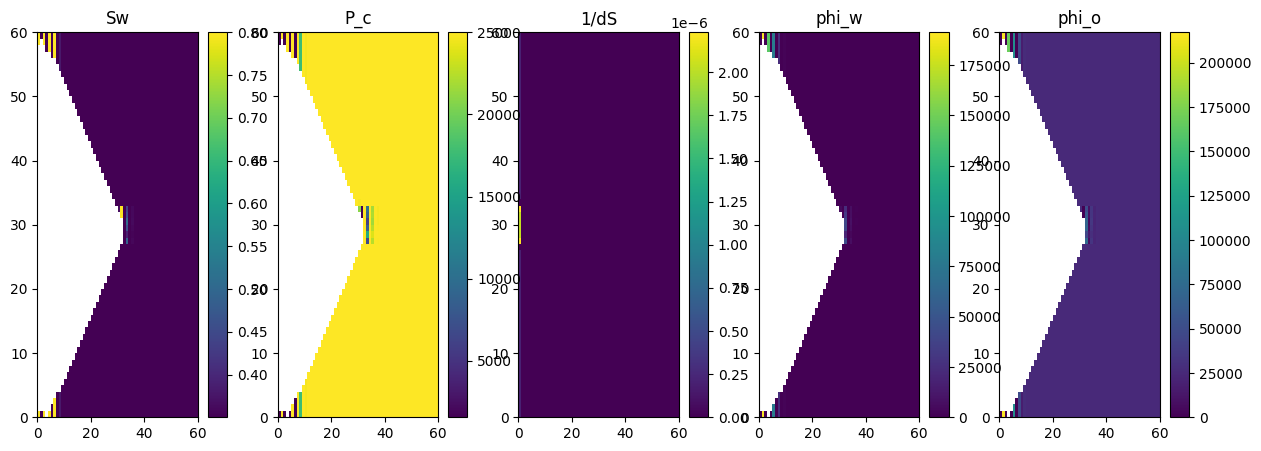

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
35


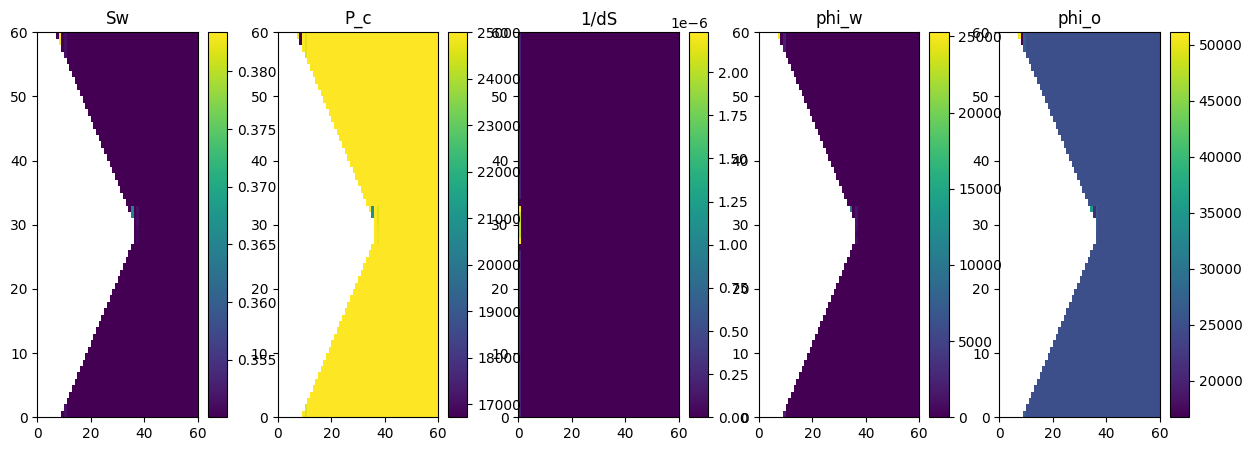

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
36


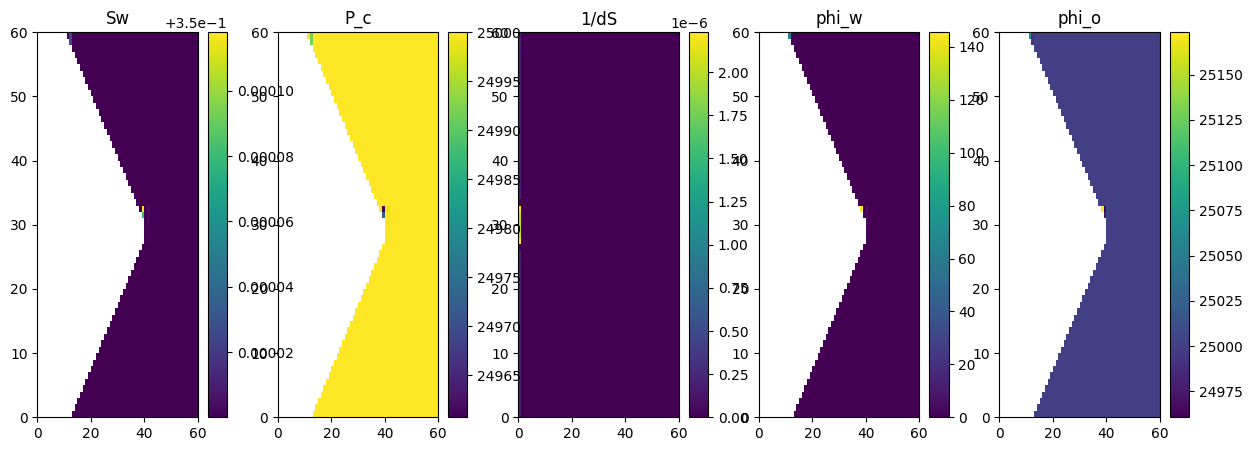

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
37


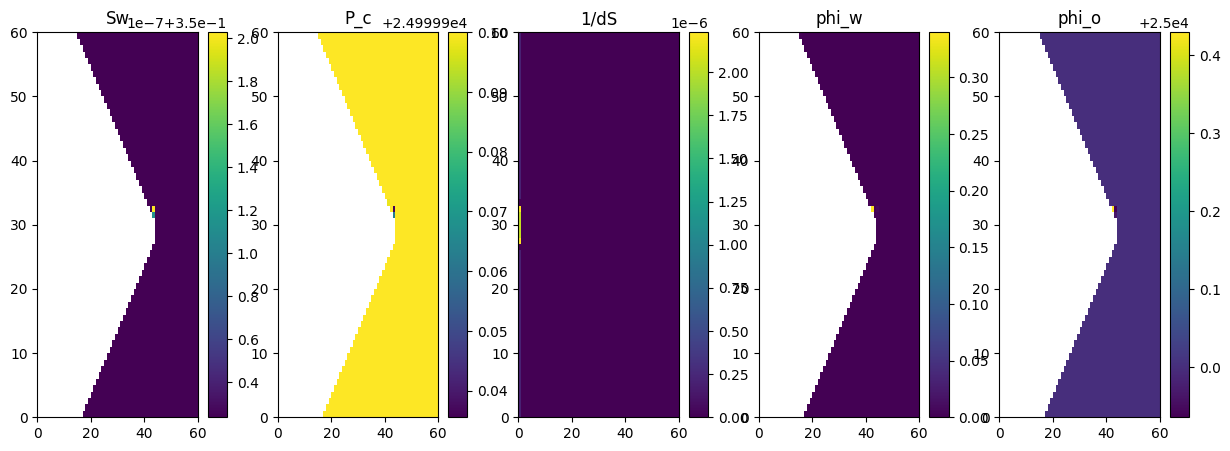

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
38


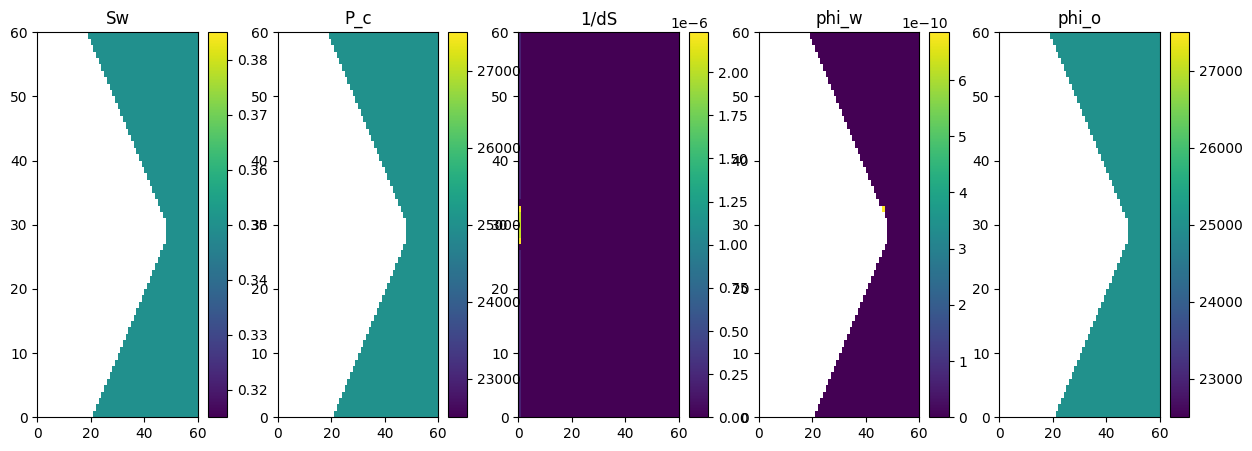

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
39


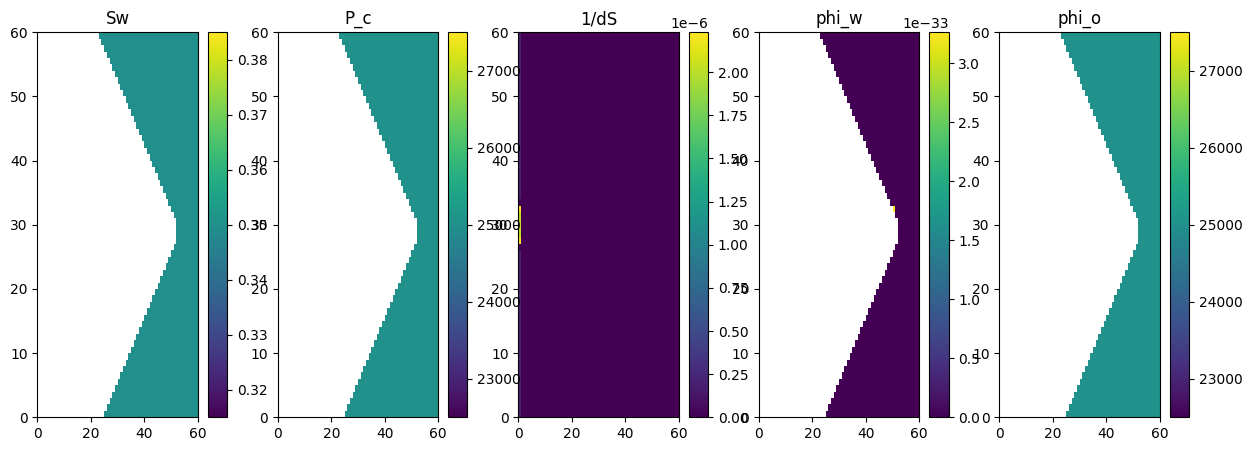

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
40


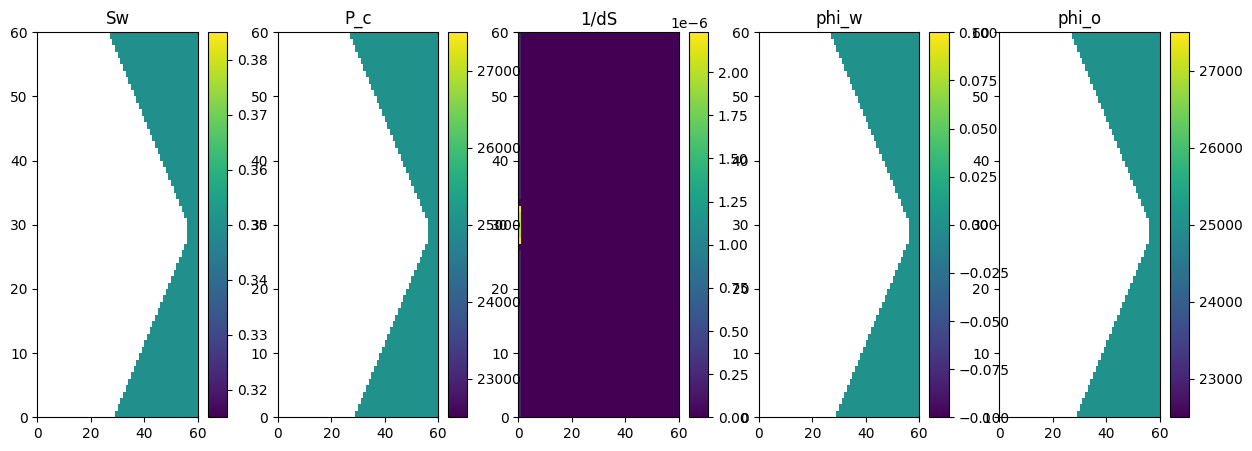

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
41


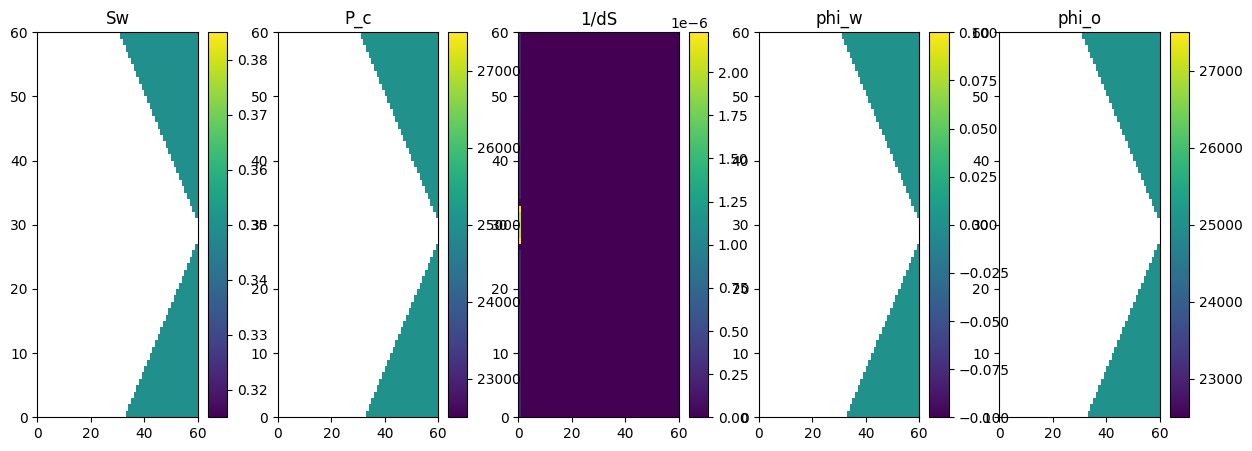

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
42


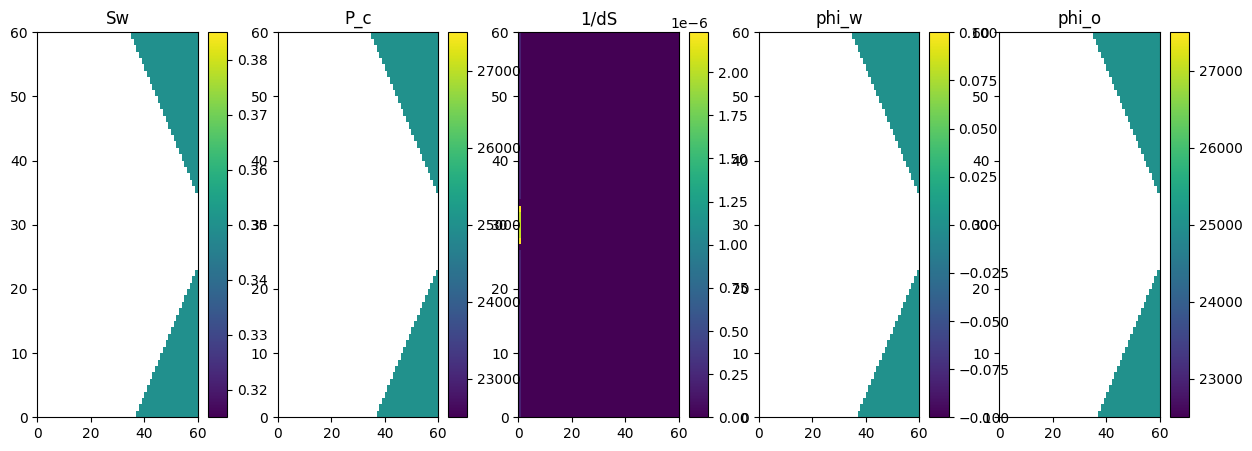

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
43


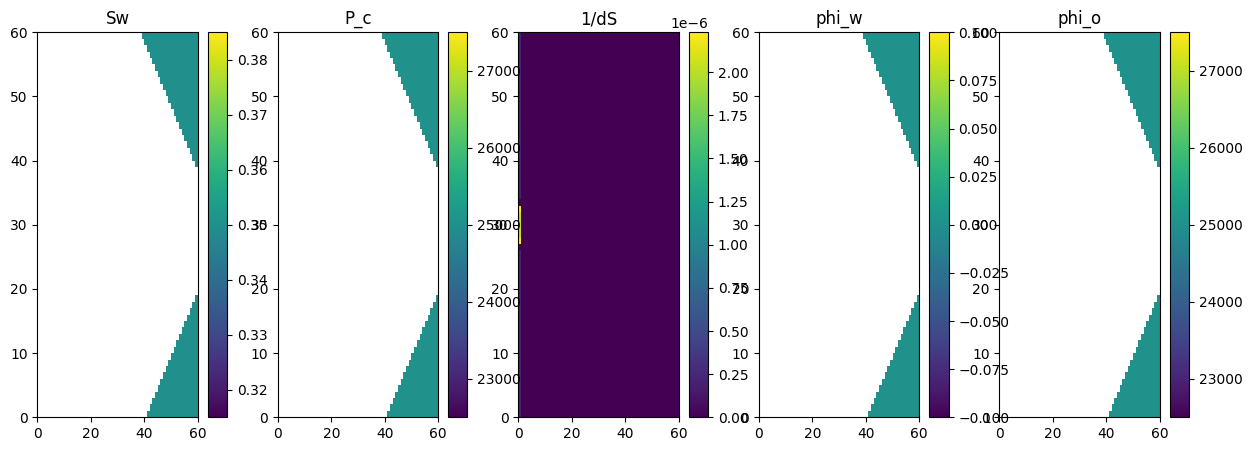

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
44


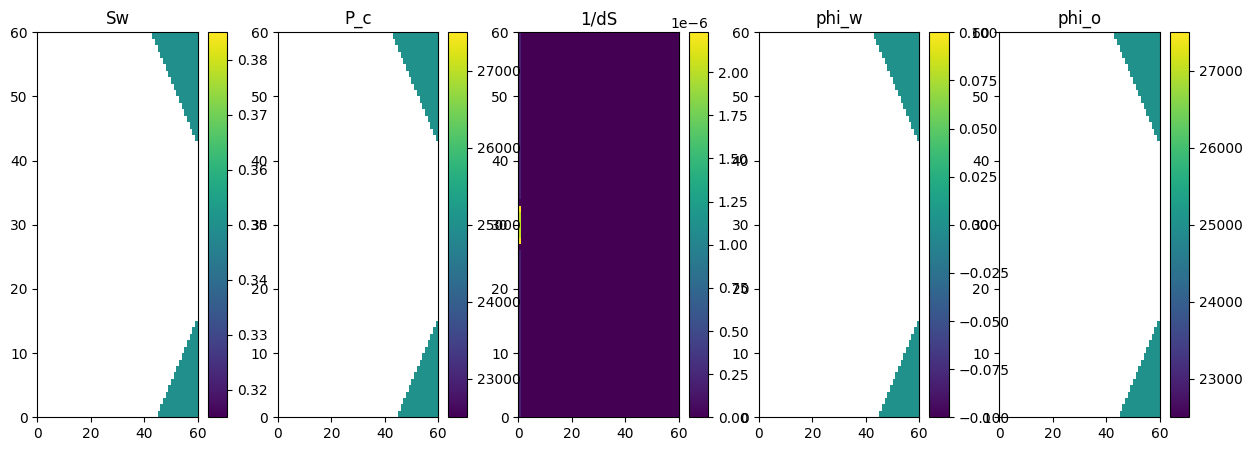

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
45


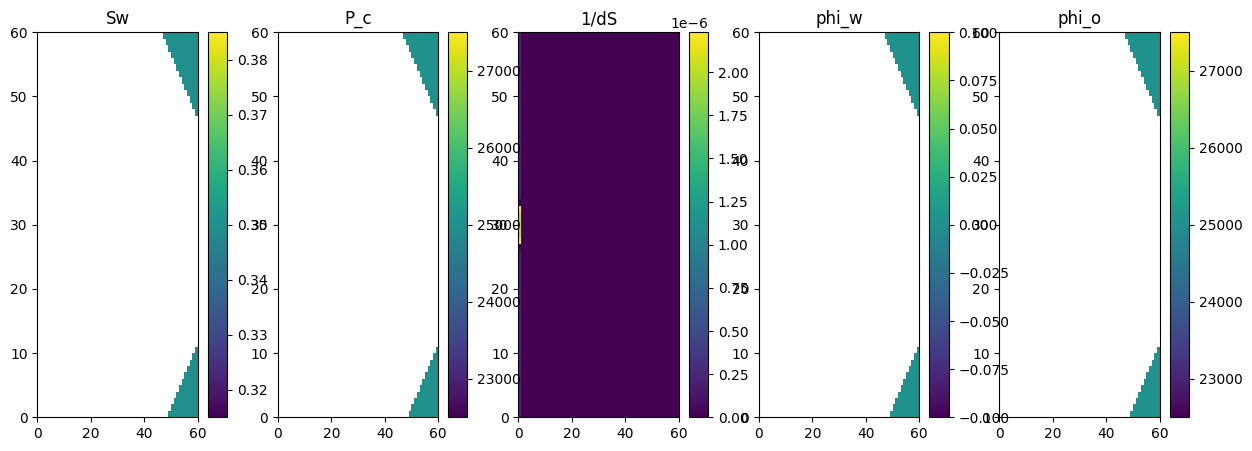

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
46


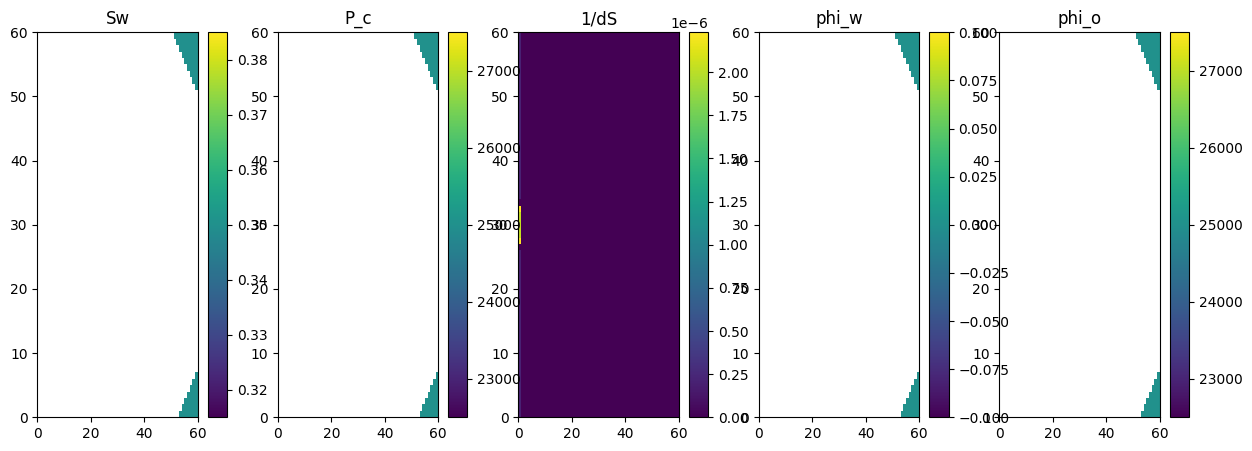

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
47


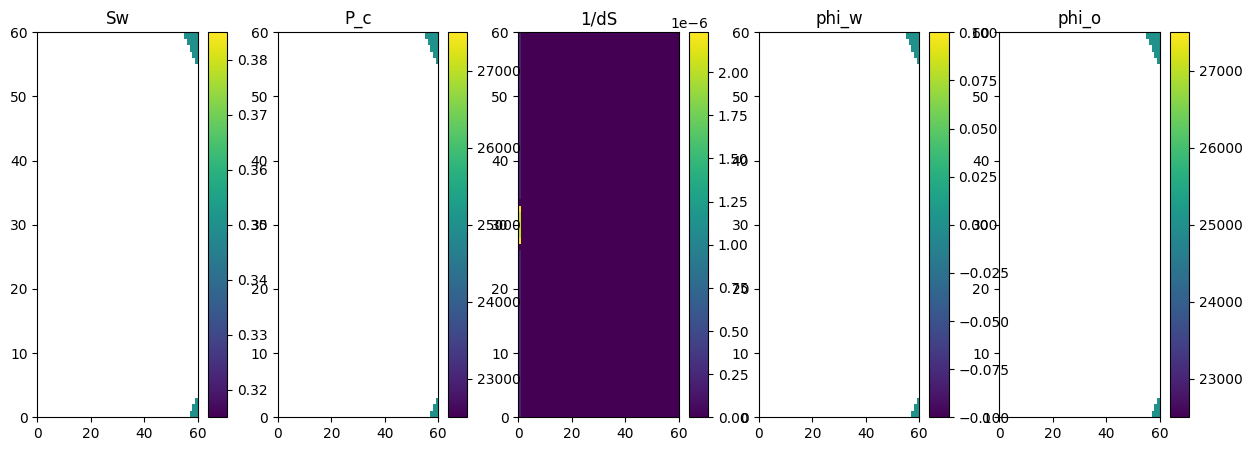

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
48


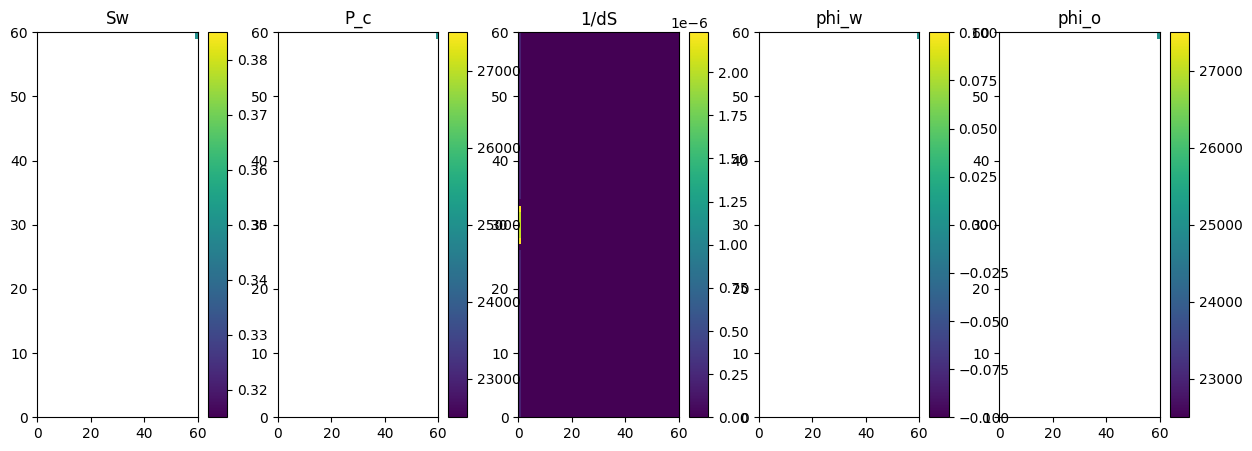

in convective_velocity
(dkᵇ=2, xˢ=60, yˢ=60) -6.45e-11 ± 1.3e-09 (-4e-08...0e+00)
dK_a(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) 5.24e-14 ± 1.2e-13 (0e+00...6e-13)
dK_b(self.K_l,p_c)
(dKKᵇ=2, dkᵇ=2, xˢ=60, yˢ=60) -7.74e-11 ± 1.8e-10 (-9e-10...0e+00)
p_c
(xˢ=60, yˢ=60) const 25000.0
Sw_pc
(xˢ=60, yˢ=60) const 0.3500000238418579
dK_ro_f(Sw_Pc_f(p_c))
(xˢ=60, yˢ=60) const -1.0697386264801025
49


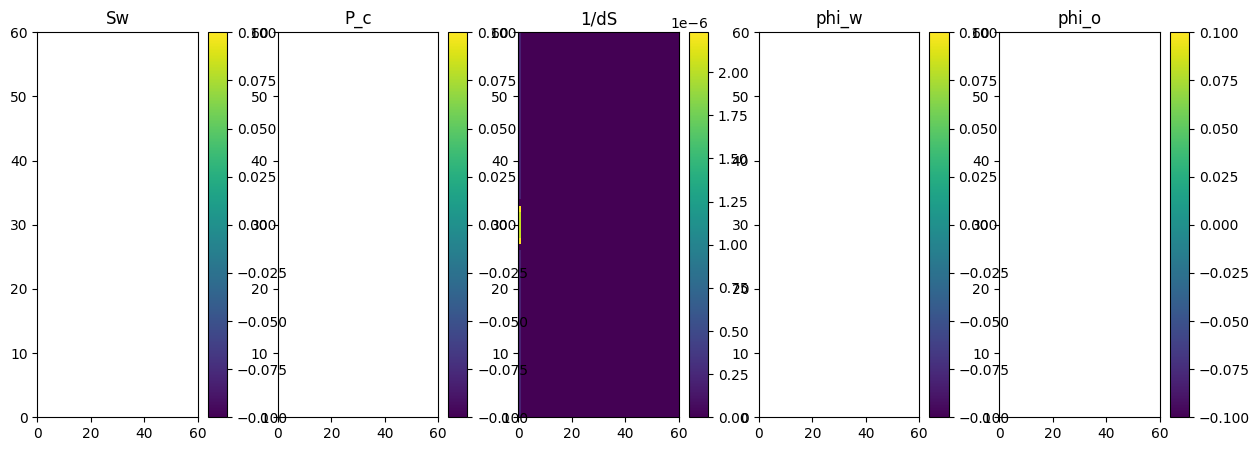

In [378]:
#for f in np.array(phi_t):
#for t,f in enumerate(phi_t[::10]):
for t,f in enumerate(phi_t[-50:]):
    fig,axs=plt.subplots(1,5,figsize=(15,5))
    #axs[0].imshow(Sw_Pc_f(phy.compute_p_c(*f)))
    pcm = axs[0].pcolormesh(Sw_Pc_f(phy.compute_p_c(*f)).numpy("y,x"))
    axs[0].title.set_text("Sw")
    fig.colorbar(pcm,ax=axs[0])
    pcm = axs[1].pcolormesh(phy.compute_p_c(*f).numpy("y,x"))
    axs[1].title.set_text("P_c")
    fig.colorbar(pcm,ax=axs[1])

    #pcm = axs[2].pcolormesh(1/dScdPc_f(phy.compute_p_c(*f)).numpy("y,x"))
    #axs[2].title.set_text("1/dS")
    #fig.colorbar(pcm,ax=axs[2])

    pcm = axs[2].pcolormesh(phi_sum(
      phy.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_o.gradient(),
      "vector").numpy("y,x"))
    axs[2].title.set_text("1/dS")
    fig.colorbar(pcm,ax=axs[2])

    pcm = axs[3].pcolormesh(f[0].numpy("y,x"))
    axs[3].title.set_text("phi_w")
    fig.colorbar(pcm,ax=axs[3])

    pcm = axs[4].pcolormesh(f[1].numpy("y,x"))
    axs[4].title.set_text("phi_o")
    fig.colorbar(pcm,ax=axs[4])


    print(t)
    plt.show()


### 2 phase flow with space dependent permeability

In [627]:
import matplotlib.pyplot as plt
import numpy as np
import sympy
from copy import deepcopy
Sw_args={
    "SWR":0.05,
    "SOC":0.20
}
Pc_args=Sw_args.copy()
Pc_args.update({
    "lam":0.5,
    "Pi":1e3
    })

SWC=sympy.symbols("S_{wc}")
SOR=sympy.symbols("S_{or}")
Sw=sympy.symbols("S_w")
lam=sympy.symbols("\lambda")
Pi=sympy.symbols("P_i")
K_rw0=sympy.symbols("k_{rw0}")
K_ro0=sympy.symbols("k_{ro0}")

Pc_=sympy.symbols("P_c")

Sc=(Sw-SWC)/(1-SWC-SOR)
Pc=Pi*Sc**(-1/lam)

Sw_Pc=(1-SWC-SOR)*((Pc_/Pi)**(-1*lam))+SWC
dScdPc=sympy.diff(Sw_Pc,Pc_)


K_rw=K_rw0*Sc**((2+3*lam)/(lam))
K_ro=K_ro0*((1-Sc)**2)*(1-Sc**((2+lam)/(lam)))

#Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,0.05,0.45,0.5,1e5)
Pc_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi),Pc)(sw,*tuple(Pc_args.values()))
Se_f=lambda sw: sympy.lambdify((Sw,SOR,SWC),Sc)(sw,*tuple(Sw_args.values()))

K_w_f_t=lambda sw: 1000.0 * 9.869233e-13
K_o_f_t=lambda sw: 1000.0 * 9.869233e-13

#sympy.diff(K_rw,Sw)
#sympy.diff(K_ro,Sw)
#dK_rw_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_rw0),sympy.diff(K_rw,Sw))(sw,*tuple(Pc_args.values()),0.3)
#dK_ro_f=lambda sw: sympy.lambdify((Sw,SOR,SWC,lam,Pi,K_ro0),sympy.diff(K_ro,Sw))(sw,*tuple(Pc_args.values()),0.5)

Sw_Pc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),Sw_Pc)(sw,*tuple(Pc_args.values()))
dScdPc_f=lambda sw: sympy.lambdify((Pc_,SOR,SWC,lam,Pi),dScdPc)(sw,*tuple(Pc_args.values()))

from phi.torch.flow import diffuse, advect, Solve, fluid, math,Field, unstack,stack,batch,field,vec
MUO=1.295
MUW=0.32
K_w=lambda p_c:stack(
    [stack([K_w_f_t(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_w_f_t(Sw_Pc_f(p_c))/(MUW*dScdPc_f(p_c))],batch("k") )],batch("KK"))

K_o=lambda p_c:stack(
    [stack([K_o_f_t(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c)),math.zeros_like(p_c)],batch("k") ),
    stack([math.zeros_like(p_c),K_o_f_t(Sw_Pc_f(p_c))/(MUO*dScdPc_f(p_c))],batch("k") )],batch("KK"))


In [628]:
from phiml.math import sum as phi_sum



class two_phase_flow_RD(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.K_o=K_o
    self.K_w=K_w


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c
    
  def phi_w_pde(self,phi_w,phi_o,dtphi_o):
    p_c=self.compute_p_c(phi_w,phi_o)
    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (dtphi_o.values)
    return phi_w.with_values(pressure_chage_term) - phi_w.with_values(w_diffusion_term)

  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    p_c=self.compute_p_c(phi_w,phi_o)

    #w_advection_term = phi_sum(self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o)*phi_w.gradient(),"vector").sample(phi_w.geometry)

    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_w.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_w.with_values(phi_sum(phi_w.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (self.dtphi_o_1.values)

    return phi_w + dt * (phi_w.with_values(pressure_chage_term) - phi_w.with_values(w_diffusion_term))
  
  def phi_o_pde(self,phi_o,phi_w,dtphi_w):
    p_c=self.compute_p_c(phi_w,phi_o)
    x,y=unstack(phi_sum(self.K_o(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_o.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (dtphi_w.values)
    return phi_o.with_values(pressure_chage_term) - phi_o.with_values(w_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    x,y=unstack(phi_sum(self.K_w(p_c),"KK"),"k")
    spatial_diffusion=Field(phi_o.geometry,values=vec(x=x,y=y))
    w_diffusion_term=phi_o.with_values(phi_sum(phi_o.gradient(2)*spatial_diffusion,"vector"))
    pressure_chage_term = (self.dtphi_w_1.values)

    return phi_o + dt * (phi_o.with_values(pressure_chage_term) - phi_o.with_values(w_diffusion_term))
  
  def RK4(self,phi_w,phi_o,dt):
    K_o1=self.phi_o_pde(phi_o,phi_w,self.dtphi_w_1)
    K_w1=self.phi_w_pde(phi_w,phi_o,self.dtphi_o_1)

    K_o2=self.phi_o_pde(phi_o,phi_w+0.5*K_o1.values*dt,K_w1)
    K_w2=self.phi_w_pde(phi_w,phi_o+0.5*K_w1.values*dt,K_o1)

    K_o3=self.phi_o_pde(phi_o,phi_w+0.5*K_o2.values*dt,K_w2)
    K_w3=self.phi_w_pde(phi_w,phi_o+0.5*K_w2.values*dt,K_o2)

    K_o4=self.phi_o_pde(phi_o,phi_w+K_o3.values*dt,K_w3)
    K_w4=self.phi_w_pde(phi_w,phi_o+K_w3.values*dt,K_o3)

    self.dtphi_o_1 = (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    self.dtphi_w_1 = (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)

    phi_o = phi_o + dt * (1/6)  * (K_o1 + 2*K_o2 + 2*K_o3 + K_o4)
    phi_w = phi_w + dt * (1/6)  * (K_w1 + 2*K_w2 + 2*K_w3 + K_w4)
    return phi_w,phi_o
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = self.phi_w_momentum_eq(phi_w,phi_o, dt)
    new_phi_o = self.phi_o_momentum_eq(phi_o,phi_w, dt)
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [595]:
Sw_Pc

S_{wc} + (-S_{or} - S_{wc} + 1)/(P_c/P_i)**\lambda

In [575]:
1/dScdPc

-P_c*(P_c/P_i)**\lambda/(\lambda*(-S_{or} - S_{wc} + 1))

In [620]:
1/dScdPc_f(1e3)

-2666.6666666666665

In [629]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *

p_o=1e4

geo=UniformGrid(x=30, y=30,bounds=Box(x=6e3, y=6e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':5e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phi_o=Field( geo,values=tensor(p_o),
      boundary= {
          'x-': p_o + 5e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': None,
          'x+': None,
          'y-': None,
          'y+': None
 })

phy=two_phase_flow_RD(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
)

print(phy.compute_p_c(phi_w,phi_o))
print(Sw_Pc_f(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(Sw_Pc_f(phy.compute_p_c(phi_w,phi_o))))
print(dScdPc_f(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(K_o(phy.compute_p_c(phi_w,phi_o)))


(xˢ=30, yˢ=30) const 10000.0
(xˢ=30, yˢ=30) const 0.4371708035469055
9.869233000000002e-10
(xˢ=30, yˢ=30) const -1.1858540347020607e-05
(KKᵇ=2, kᵇ=2, xˢ=30, yˢ=30) -1.30e-04 ± 1.3e-04 (-3e-04...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=30, yˢ=30) -3.21e-05 ± 3.2e-05 (-6e-05...0e+00)


In [630]:
phi_t=[]
phi=(phi_w,phi_o)
phi_t.append(phi)
for i in range(500):
    phi=phy.RK4(*phi,1e3)
    #phi=phy.implicit_time_step(*phi,1e5)
    phi_t.append(phi)
    if np.isnan(np.sum(Sw_Pc_f(phy.compute_p_c(*phi)).numpy("x,y"))):
        print("nan")
        print(i)
        break

nan
357


In [610]:
i

92

0


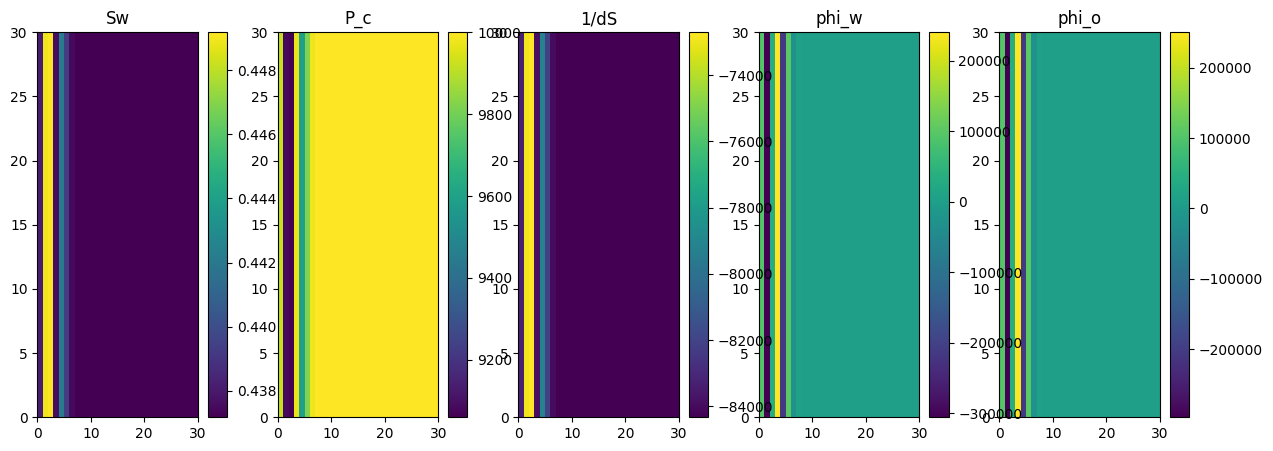

1


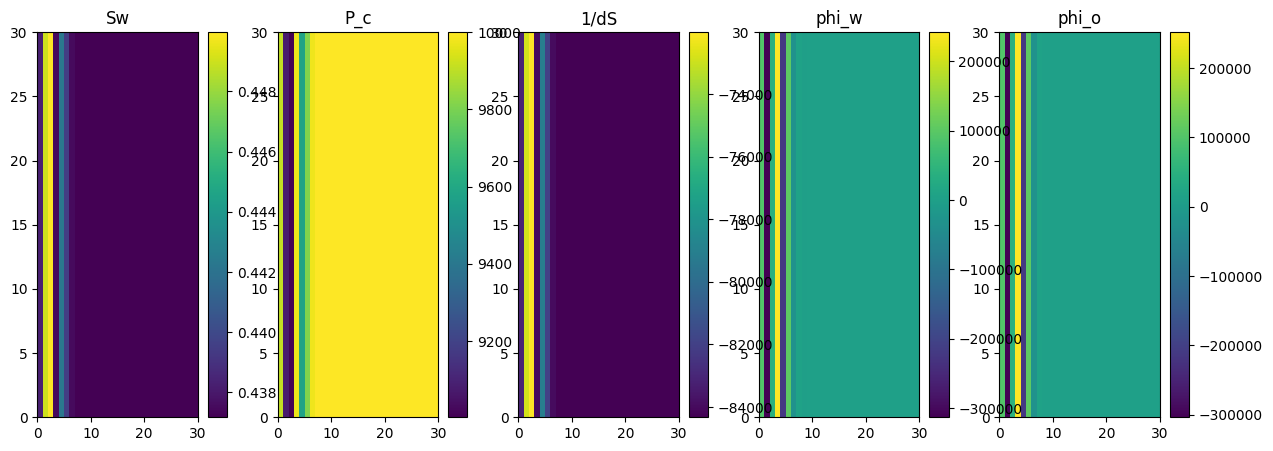

2


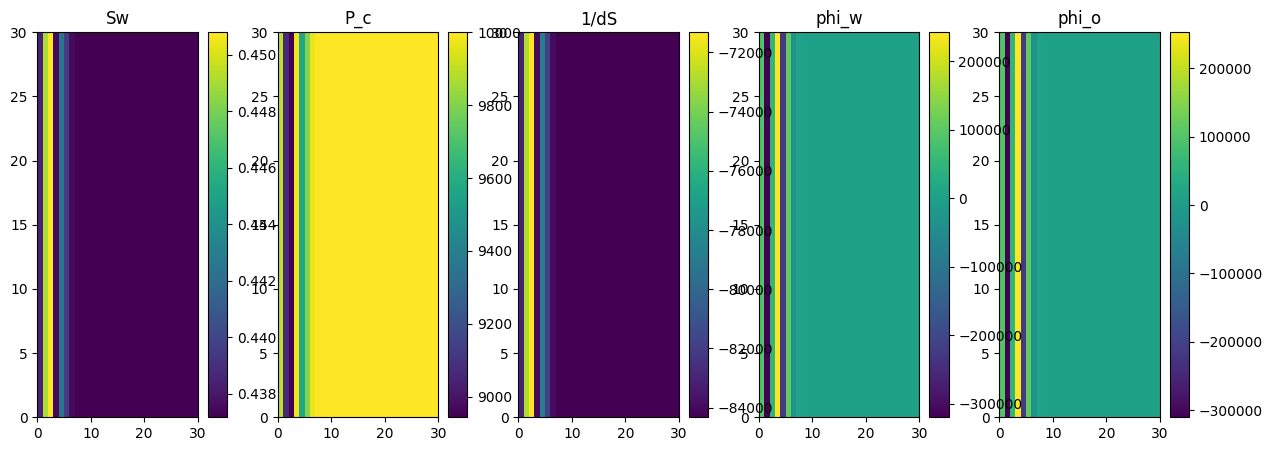

3


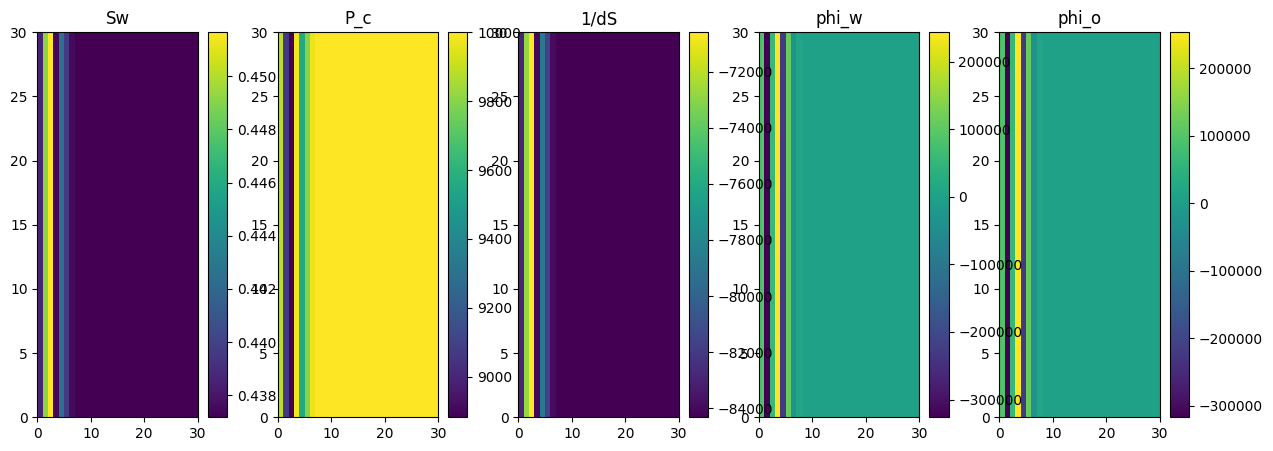

4


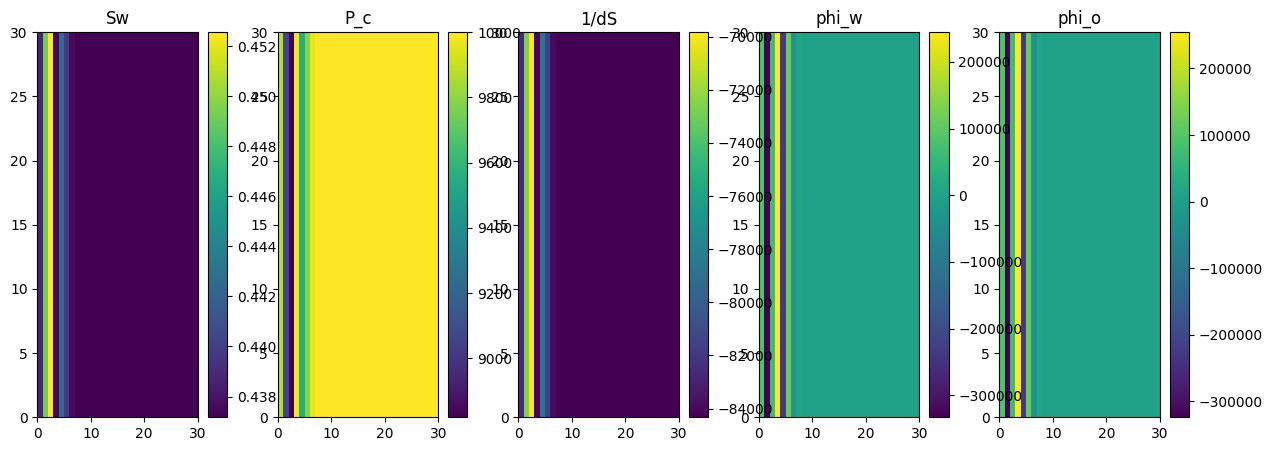

5


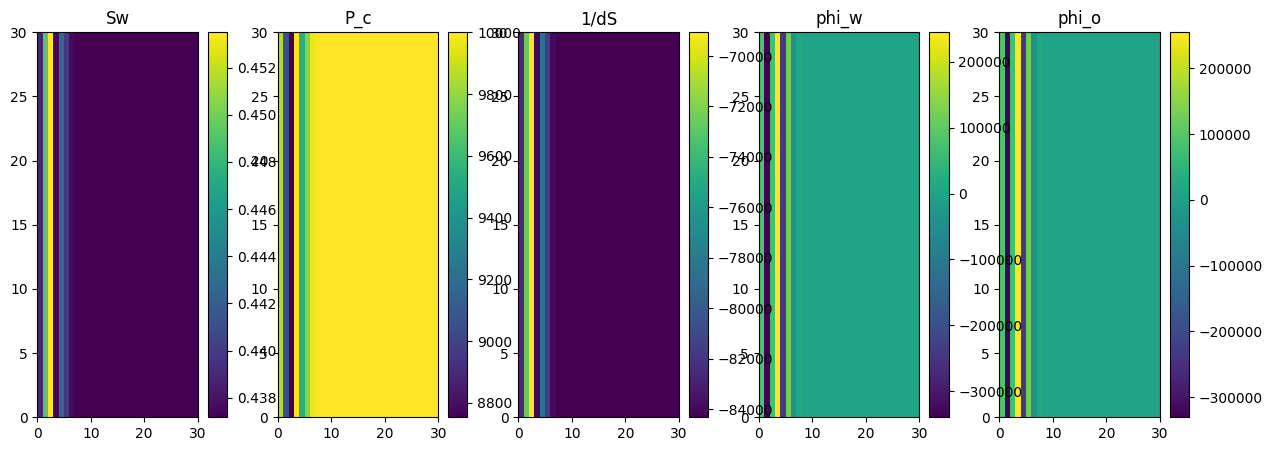

6


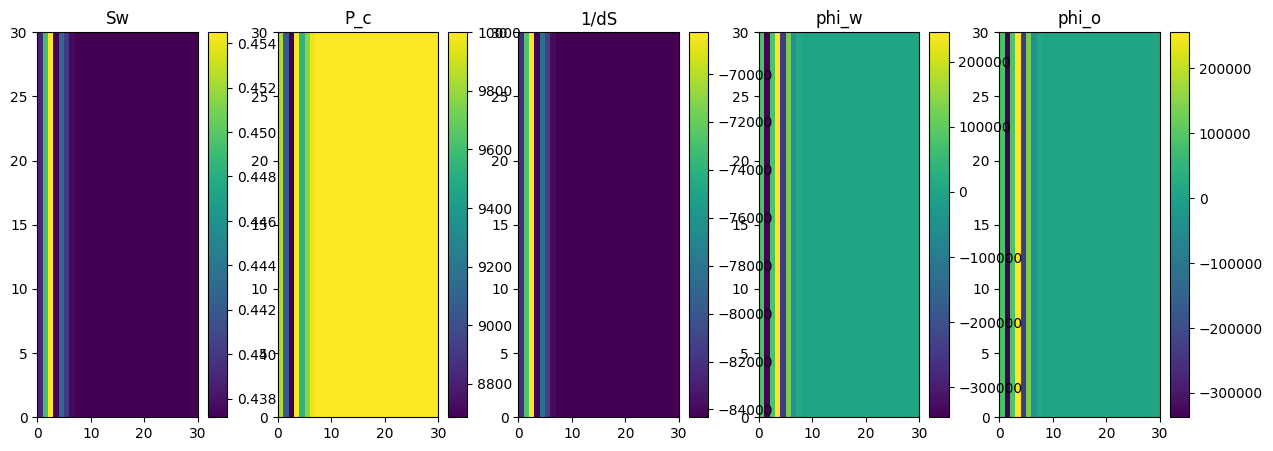

7


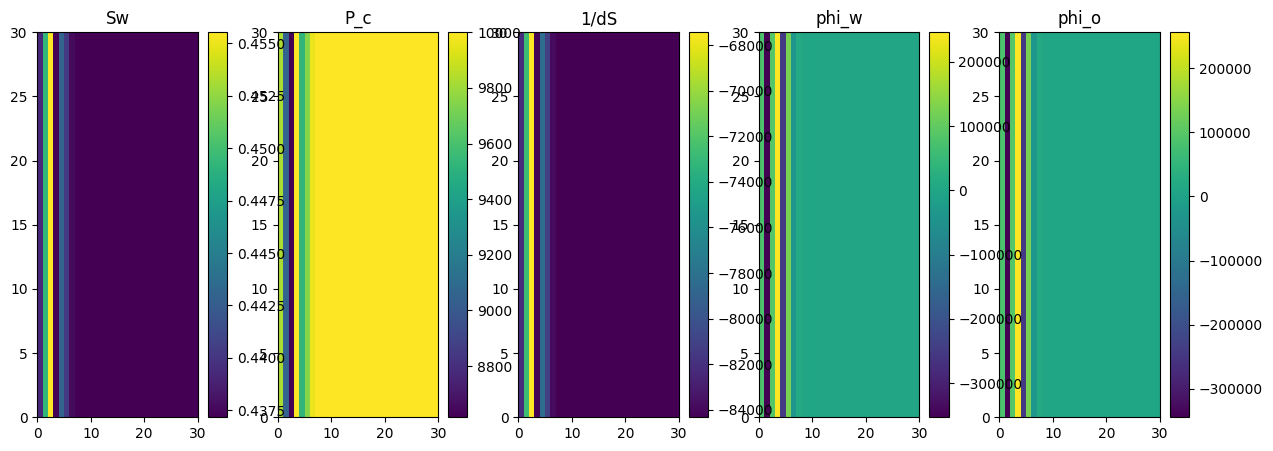

8


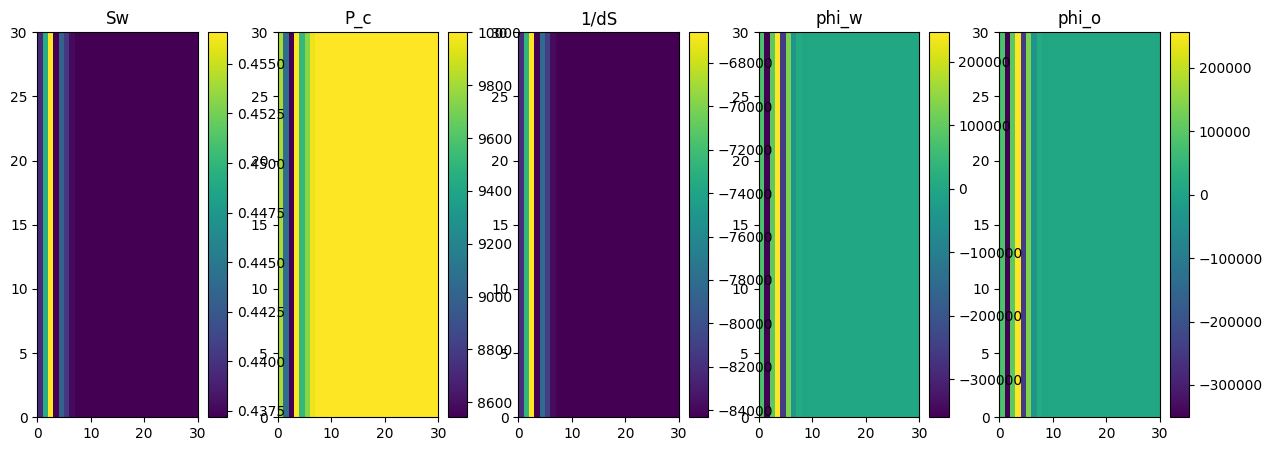

9


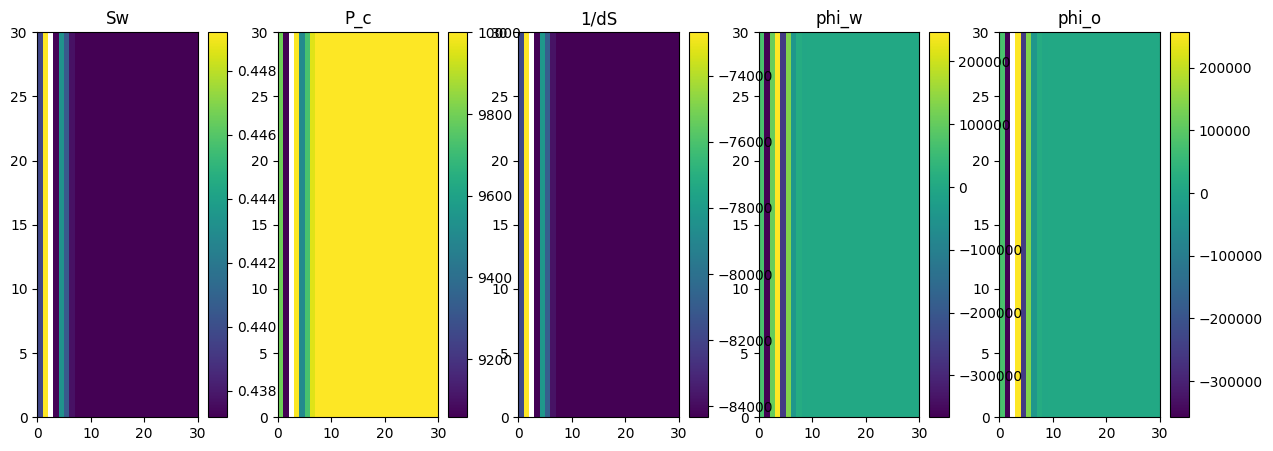

In [631]:

#for f in np.array(phi_t):
#for t,f in enumerate(phi_t[::10]):
for t,f in enumerate(phi_t[-10:]):
    fig,axs=plt.subplots(1,5,figsize=(15,5))
    #axs[0].imshow(Sw_Pc_f(phy.compute_p_c(*f)))
    pcm = axs[0].pcolormesh(Sw_Pc_f(phy.compute_p_c(*f)).numpy("y,x"))
    axs[0].title.set_text("Sw")
    fig.colorbar(pcm,ax=axs[0])
    pcm = axs[1].pcolormesh(phy.compute_p_c(*f).numpy("y,x"))
    axs[1].title.set_text("P_c")
    fig.colorbar(pcm,ax=axs[1])

    pcm = axs[2].pcolormesh(1/dScdPc_f(phy.compute_p_c(*f)).numpy("y,x"))
    axs[2].title.set_text("1/dS")
    fig.colorbar(pcm,ax=axs[2])

    pcm = axs[3].pcolormesh(f[0].numpy("y,x"))
    axs[3].title.set_text("phi_w")
    fig.colorbar(pcm,ax=axs[3])

    pcm = axs[4].pcolormesh(f[1].numpy("y,x"))
    axs[4].title.set_text("phi_o")
    fig.colorbar(pcm,ax=axs[4])


    print(t)
    plt.show()



In [150]:
Sw_Pc_f(phy.compute_p_c(*f)).numpy("x,y")

array([[0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       ...,
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139],
       [0.6081139, 0.6081139, 0.6081139, ..., 0.6081139, 0.6081139,
        0.6081139]], dtype=float32)